# Uso de este cuaderno

ESTE CUADERNO HA SIDO ENTRENADO EN GOOGLE COLAB  
Primeramente se ejecuta el preprocesamiento de datos depsues se elige las variables que se quieran probar y luego el modelo.  
En la sección "Carga de datos" de este mismo cuaderno se pueden obtener los datos preprocesados para no tener que ejecutar la sección otra vez (la carga se hace desde un archivo .pkl que tiene que estar en la misma carpeta que este cuaderno), esto facilita el uso en cuanto a tiempo.   


Cada modelo está guardado en su respectivo archivo .pkl(su ubicación tiene que ser la misma que este cuaderno jupiter) el cual ya esta entrenado, esto sirve para no tener que ejecutar otra vez el entrenamiento de los modelos. La carga de cada modelo se puede encontrar en su correspondiente sección.  
Por ejempo, para ejecutar un modelo de regresión logística hay que ejecutar la celda de Importaciones, luego cargar los datos (sección "Carga de datos") y tras esto ejecutar la celda de Selección de variables (se elige qué se va a meter en el modelo: metricas, textos, titulos o una combinación de los anteriores), luego ir a Modelos Machine learning, buscar la sección Regresión logística y ejecutar la sección de "Guardado y carga del modelo" y "predicción y evaluación".  
Resumen de ejecución del ejemplo:
* Importaciones
* Carga de datos
* Selección de variables
* Guardado y carga del modelo
* Predicción y evaluación

# Preprocesamiento de los datos

## Importaciones

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import random
import string
import joblib
import pickle
import openpyxl
# import spacy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score

from tensorflow import keras
from keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TextVectorization, Input, Embedding, Flatten, Concatenate,MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, Concatenate, Conv1D, MaxPooling1D,LSTM, BatchNormalization,GRU
! pip install keras_nlp
import keras_nlp

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC



from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


# RANDOM SEED o RANDOM STATE
##### Se establece una semilla para que la separación de grupo de train test y el resultado de los modelos den siempre el mismo resultado #####

# Se usa RandomState de numpy pues un random.seed() no funciona con los modelos. Información obtenida de la siguiente fuente https://stackoverflow.com/questions/40750394/how-to-seed-the-random-number-generator-for-scikit-learn
from numpy.random import RandomState
RandomState(42)
tf.random.set_seed(42)
np.random.seed(42)

# Se usa el parámetro random_state de los modelos en vez de RandomState de numpy
# En la redes neuronales sí se usa

# Función para visualizar el area bajo la curva o curva Roc
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, color='orange', label='ROC curve of class (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Base estimator')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.4/548.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.6 MB/s eta 0:00:00


## Carga y comprobación de los datos

In [ ]:
# Ruta para ejecutar en local
df_noticias = pd.read_csv("data/Noticias_sin_duplicados.csv", sep='|')

print(df_noticias.shape)
df_noticias.head(3)

(6008, 19)


,id_noticia,cont_titulo,cont_texto,compartir_tiempo,real_fake,autor,fuente,visitas,compartir,duracion,favorito,pais,idioma,tiempo,tipo,real_fake_integer,real_fake_bool,tiempo_encode,tiempo_comparticion_encode
0,10,Scalia’s death comes just a month before the c...,The unexpected death of Justice Antonin Scalia...,2022-09-08 14:00:00,REAL,Zoe Lee,The Insight,24881,59275,558,5035,Philippines,English,2022-09-07 13:00:00,Entrevista,0,False,540000,630000
1,100,Rachel Dolezal's brother: She's 'making up mor...,(CNN) Ezra Dolezal would love to see his siste...,2022-09-18 00:00:00,REAL,Nora Patel,Newsline,737334,60949,279,9823,Italy,English,2022-09-08 17:00:00,Reportaje especial,0,False,640800,1443600
2,10001,What A Hillary Presidency Would Bring,"Behind the headlines - conspiracies, cover-ups...",2022-09-24 07:00:00,FAKE,Grace Liu,Newsline,563200,10094,432,5226,Egypt,English,2022-09-11 11:00:00,Reseña,1,True,878400,1987200


In [ ]:
df_noticias.isna().sum().sum()

0

In [ ]:
df_noticias['real_fake'].value_counts()

,count
real_fake,
FAKE,3023
REAL,2985


In [ ]:
print(df_noticias.columns.to_list())

['id_noticia', 'cont_titulo', 'cont_texto', 'compartir_tiempo', 'real_fake', 'autor', 'fuente', 'visitas', 'compartir', 'duracion', 'favorito', 'pais', 'idioma', 'tiempo', 'tipo', 'real_fake_integer', 'real_fake_bool', 'tiempo_encode', 'tiempo_comparticion_encode']


In [ ]:
# df_noticias.drop(columns=['anio_publicacion', 'mes_publicacion', 'dia_publicacion','hora_publicacion', 'anio_comparticion', 'mes_comparticion','dia_comparticion', 'hora_comparticion','real_fake_bool'], inplace=True)

In [ ]:
print(df_noticias.columns.to_list())

['id_noticia', 'cont_titulo', 'cont_texto', 'compartir_tiempo', 'real_fake', 'autor', 'fuente', 'visitas', 'compartir', 'duracion', 'favorito', 'pais', 'idioma', 'tiempo', 'tipo', 'real_fake_integer', 'real_fake_bool', 'tiempo_encode', 'tiempo_comparticion_encode']


In [ ]:
# # Tarda bastante, se deja comentado para agilizar la preparación de los datos
# plt.figure(figsize=(20,20))
# sns.pairplot(df_noticias, hue='real_fake_integer', palette='mako')
# plt.show()

### Correlación

In [ ]:
# Correlación con id_noticia
df_noticias.corr(numeric_only=True)

,id_noticia,visitas,compartir,duracion,favorito,real_fake_integer,real_fake_bool,tiempo_encode,tiempo_comparticion_encode
id_noticia,1.000000,-0.005413,-0.010709,-0.018542,-0.004288,0.001033,0.001033,-0.005414,-0.020658
visitas,-0.005413,1.000000,-0.000166,-0.014619,0.004101,-0.015181,-0.015181,-0.004344,0.001712
compartir,-0.010709,-0.000166,1.000000,0.013845,0.021608,0.016228,0.016228,-0.004243,0.003586
duracion,-0.018542,-0.014619,0.013845,1.000000,-0.002119,0.001092,0.001092,-0.000067,-0.009760
favorito,-0.004288,0.004101,0.021608,-0.002119,1.000000,-0.012785,-0.012785,-0.009154,0.019641
real_fake_integer,0.001033,-0.015181,0.016228,0.001092,-0.012785,1.000000,1.000000,0.019302,0.010827
real_fake_bool,0.001033,-0.015181,0.016228,0.001092,-0.012785,1.000000,1.000000,0.019302,0.010827
tiempo_encode,-0.005414,-0.004344,-0.004243,-0.000067,-0.009154,0.019302,0.019302,1.000000,0.028272
tiempo_comparticion_encode,-0.020658,0.001712,0.003586,-0.009760,0.019641,0.010827,0.010827,0.028272,1.000000


### Comparación de variables dos a dos

In [ ]:
# # Tarda bastante, se deja comentado para agilizar la preparación de los datos
# plt.figure(figsize=(20,20))
# sns.pairplot(df_noticias, hue='real_fake_integer', palette='mako')
# plt.show()

No se mete id_noticias en los modelos pues no tiene sentido, además desvirtua mucho los resultados porque esta muy correlado con la variable objetivo (real_fake)

In [ ]:
df_noticias[['real_fake', 'real_fake_integer']].head()

,real_fake,real_fake_integer
0,REAL,0
1,REAL,0
2,FAKE,1
3,FAKE,0
4,FAKE,1


In [ ]:
corr = df_noticias.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,id_noticia,visitas,compartir,duracion,favorito,real_fake_integer,real_fake_bool,tiempo_encode,tiempo_comparticion_encode
id_noticia,1.000000,-0.005413,-0.010709,-0.018542,-0.004288,0.001033,0.001033,-0.005414,-0.020658
visitas,-0.005413,1.000000,-0.000166,-0.014619,0.004101,-0.015181,-0.015181,-0.004344,0.001712
compartir,-0.010709,-0.000166,1.000000,0.013845,0.021608,0.016228,0.016228,-0.004243,0.003586
duracion,-0.018542,-0.014619,0.013845,1.000000,-0.002119,0.001092,0.001092,-0.000067,-0.009760
favorito,-0.004288,0.004101,0.021608,-0.002119,1.000000,-0.012785,-0.012785,-0.009154,0.019641
real_fake_integer,0.001033,-0.015181,0.016228,0.001092,-0.012785,1.000000,1.000000,0.019302,0.010827
real_fake_bool,0.001033,-0.015181,0.016228,0.001092,-0.012785,1.000000,1.000000,0.019302,0.010827
tiempo_encode,-0.005414,-0.004344,-0.004243,-0.000067,-0.009154,0.019302,0.019302,1.000000,0.028272
tiempo_comparticion_encode,-0.020658,0.001712,0.003586,-0.009760,0.019641,0.010827,0.010827,0.028272,1.000000


## Codificación  
Df codificado con métricas, fechas luego se añaden las variables categóricas con One Hot encoder y los textos se tokenizan, variable objetivo se deja fuera en un array.   
Cuantas más variables se metan en los modelos, más tiempo se tarda en entrenar.

In [ ]:
lb = LabelBinarizer()

# Se crea df_codificado vacío
df_codificado = pd.DataFrame()


# Textos
df_codificado['cont_texto'] = df_noticias['cont_texto']
df_codificado['cont_titulo'] = df_noticias['cont_titulo']


# Métricas
df_codificado['visitas'] = df_noticias['visitas']
df_codificado['compartir'] = df_noticias['compartir']
df_codificado['duracion'] = df_noticias['duracion']
df_codificado['favorito'] = df_noticias['favorito']
df_codificado['tiempo_encode'] = df_noticias['tiempo_encode']
df_codificado['tiempo_comparticion_encode'] = df_noticias['tiempo_comparticion_encode']


# Variable objetivo
y = pd.DataFrame(lb.fit_transform(df_noticias['real_fake']), columns=['real_fake'])

print(f"Tipo de dato de y : {type(y)}")
# print(df_codificado.shape)
# print(df_codificado.columns)
display(df_codificado.head(3))
display(y)

Tipo de dato de y : <class 'pandas.core.frame.DataFrame'>


,cont_texto,cont_titulo,visitas,compartir,duracion,favorito,tiempo_encode,tiempo_comparticion_encode
0,The unexpected death of Justice Antonin Scalia...,Scalia’s death comes just a month before the c...,24881,59275,558,5035,540000,630000
1,(CNN) Ezra Dolezal would love to see his siste...,Rachel Dolezal's brother: She's 'making up mor...,737334,60949,279,9823,640800,1443600
2,"Behind the headlines - conspiracies, cover-ups...",What A Hillary Presidency Would Bring,563200,10094,432,5226,878400,1987200


,real_fake
0,1
1,1
2,0
3,0
4,0
...,...
6003,1
6004,0
6005,0
6006,0


In [ ]:
# One Hot Encoding para variables categóricas
ohe = OneHotEncoder()


# Autor
X_autor = df_noticias['autor'].values.reshape(-1, 1)
ohe_autor = ohe.fit_transform(X_autor).toarray()

# Fuente
X_fuente = df_noticias['fuente'].values.reshape(-1, 1)
ohe_fuente = ohe.fit_transform(X_fuente).toarray()

# Pais
X_pais = df_noticias['pais'].values.reshape(-1, 1)
ohe_pais = ohe.fit_transform(X_pais).toarray()

# # Idioma
# X_idioma = df_noticias['idioma'].values.reshape(-1, 1)
# ohe_idioma = ohe.fit_transform(X_idioma).toarray()

# Tipo
X_tipo = df_noticias['tipo'].values.reshape(-1, 1)
ohe_tipo = ohe.fit_transform(X_tipo).toarray()



########### Unir los ohe al df_codificado ############

df_autor = pd.DataFrame(ohe_autor, columns=df_noticias['autor'].unique())
df_codificado = pd.concat([df_codificado,df_autor], axis=1)

df_fuente = pd.DataFrame(ohe_fuente, columns=df_noticias['fuente'].unique())
df_codificado = pd.concat([df_codificado,df_fuente], axis=1)

df_pais = pd.DataFrame(ohe_pais, columns=df_noticias['pais'].unique())
df_codificado = pd.concat([df_codificado,df_pais], axis=1)

# df_idioma = pd.DataFrame(ohe_idioma, columns=df_noticias['idioma'].unique())
# df_codificado = pd.concat([df_codificado,df_idioma], axis=1)

df_tipo = pd.DataFrame(ohe_tipo, columns=df_noticias['tipo'].unique())
df_codificado = pd.concat([df_codificado,df_tipo], axis=1)

print(df_codificado.shape)
display(df_codificado.head(3))

(6008, 132)


,cont_texto,cont_titulo,visitas,compartir,duracion,favorito,tiempo_encode,tiempo_comparticion_encode,Zoe Lee,Nora Patel,...,Reportaje,Carta al editor,Análisis,Noticia destacada,Columna de humor,Crónica,Noticia internacional,Columna,Entrevista exclusiva,Noticia local
0,The unexpected death of Justice Antonin Scalia...,Scalia’s death comes just a month before the c...,24881,59275,558,5035,540000,630000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,(CNN) Ezra Dolezal would love to see his siste...,Rachel Dolezal's brother: She's 'making up mor...,737334,60949,279,9823,640800,1443600,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"Behind the headlines - conspiracies, cover-ups...",What A Hillary Presidency Would Bring,563200,10094,432,5226,878400,1987200,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Separación de los datos en grupo de train y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_codificado, y, test_size=.15, random_state=32)


print(type(X_train))
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print()
print("X_test",X_test.shape)
print("y_test",y_test.shape)

<class 'pandas.core.frame.DataFrame'>
X_train (5106, 132)
y_train (5106, 1)

X_test (902, 132)
y_test (902, 1)


In [ ]:
X_train.head(3)

,cont_texto,cont_titulo,visitas,compartir,duracion,favorito,tiempo_encode,tiempo_comparticion_encode,Zoe Lee,Nora Patel,...,Reportaje,Carta al editor,Análisis,Noticia destacada,Columna de humor,Crónica,Noticia internacional,Columna,Entrevista exclusiva,Noticia local
5607,The FBI is now actively and aggressively probi...,The Clinton FBI Investigation Just Got Real,1701,44912,582,973,1922400,986400,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3818,Rep. Paul Ryan must step down as Speaker of th...,Paul Ryan Must Step Down as Speaker of the House,390182,53239,711,3792,1530000,1724400,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4102,What Does Victory Mean For NATO? NPR. Charles ...,Links 11/12/16,328215,32353,372,1373,914400,1807200,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Comprobación balance variable objetivo
print(y_train.value_counts())
print(y_test.value_counts())

real_fake
0            2554
1            2552
Name: count, dtype: int64
real_fake
0            469
1            433
Name: count, dtype: int64


## Comprobación de longitud de palabras y vocabulario

### Textos

In [ ]:
###### Comprobación de la longtud maxima y vocabulario de los textos en 'cont_texto' de X_train ######

vectorize_layer_textos = TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode='int'
)
vectorize_layer_textos.adapt(X_train['cont_texto'].values)
textos_tokenizados = vectorize_layer_textos(X_train['cont_texto'].values)


longitud_maxima_textos = textos_tokenizados.shape[1]
longitu_maxima_vocabulario = vectorize_layer_textos.vocabulary_size()
vocabulario_textos = vectorize_layer_textos.get_vocabulary()

print(textos_tokenizados.shape)
print(textos_tokenizados)

print(f"Longitud de palabras máxima {longitud_maxima_textos}")
print(f"Cantidad palabras en el vocabulario {longitu_maxima_vocabulario}")


## Comprobación de las palabras que han sido tokenizadas

# for i, text in enumerate(df_prueba['cont_texto']):
#     # print(f"Texto original: {text}")
#     token_ids = textos_tokenizados[i].numpy()
#     tokens = [vocab[token_id] for token_id in token_ids if token_id < len(vocab)]
#     print(f"Palabras tokenizadas: {tokens}\n")

(5106, 20457)
tf.Tensor(
[[    2   221     9 ...     0     0     0]
 [  868   414   683 ...     0     0     0]
 [   51   191   509 ...     0     0     0]
 ...
 [ 2407   586    31 ...     0     0     0]
 [35460  9146     6 ...     0     0     0]
 [  278    25    89 ...     0     0     0]], shape=(5106, 20457), dtype=int64)
Longitud de palabras máxima 20457
Cantidad palabras en el vocabulario 76671


In [ ]:
# Siendo el tamaño del vocabulario de 76671 se escoge un max_features de 10000
max_features_textos = 10000

In [ ]:
# Una forma de contar las palabras por registro
numero_palabras = np.count_nonzero(textos_tokenizados, axis = 1)
print(numero_palabras)
print()

# Otra frma de contar la cantidad de palabras en cada secuencia tokenizada
df = pd.DataFrame()

longitudes_textos = tf.reduce_sum(tf.cast(textos_tokenizados > 0, tf.int32), axis=1)
df['cantidad_palabras_textos'] = longitudes_textos.numpy()
print(df['cantidad_palabras_textos'])
print(len(longitudes_textos))

[149 246 636 ... 262 322 987]

0        149
1        246
2        636
3        455
4        297
        ... 
5101     918
5102    1323
5103     262
5104     322
5105     987
Name: cantidad_palabras_textos, Length: 5106, dtype: int32
5106


Mediana: 614.0
Media 791.8419506462985


<Axes: >

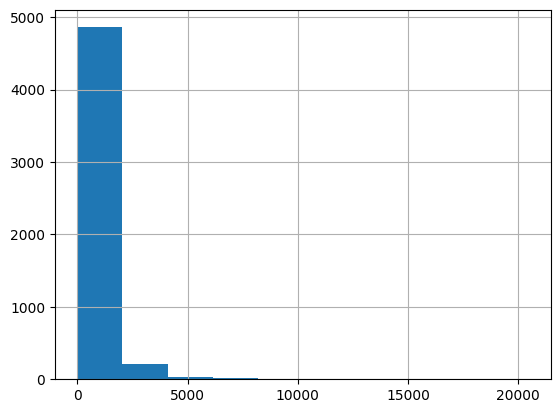

In [ ]:
print("Mediana:",df['cantidad_palabras_textos'].median())
print("Media",df['cantidad_palabras_textos'].mean())
df['cantidad_palabras_textos'].hist()

In [ ]:
# Se crea sequence_legth
# Comprobación del balance de ese % de registros con mayor cantidad de palabras que el quantil especficado

cuantil = 0.60
sequence_length_textos = int(df['cantidad_palabras_textos'].quantile(cuantil))
print(f"Valor del cuantil {cuantil}: {sequence_length_textos}")

# Se crea una columna con la cantidad de palabras de la columna cont_texto que hay en cada registro
df_noticias['cantidad_palabras_textos'] = df['cantidad_palabras_textos']

# Se filtra ese % de registros que tienen mayor cantidad de palabras
registros_mayor_cantidad_palabras = df_noticias[df_noticias['cantidad_palabras_textos'] > sequence_length_textos]

print(f"{len(registros_mayor_cantidad_palabras)} registros que se va a cortar su longitud")
display(registros_mayor_cantidad_palabras.groupby('real_fake').agg({'id_noticia':'count'}))

# Por último, se elimina la columna de apoyo, ya no hace falta
df_noticias.drop(columns='cantidad_palabras_textos', inplace=True)

Valor del cuantil 0.6: 759
2042 registros que se va a cortar su longitud


,id_noticia
real_fake,
FAKE,858
REAL,1184


### Titulos

In [ ]:
###### Comprobación de la longtud maxima y vocabulario de los textos en 'cont_texto' de X_train ######

vectorize_layer_titulos = TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode='int'
)
vectorize_layer_titulos.adapt(X_train['cont_titulo'].values)
titulos_tokenizados = vectorize_layer_textos(X_train['cont_titulo'].values)


longitud_maxima_titulo = titulos_tokenizados.shape[1]
longitud_maxima_vocabulario = vectorize_layer_titulos.vocabulary_size()
vocabulario_titulos = vectorize_layer_titulos.get_vocabulary()


print(titulos_tokenizados.shape)
# print(titulos_tokenizados)

print(f"Longitud de palabras máxima {longitud_maxima_titulo}")
print(f"Cantidad palabras en el vocabulario {longitud_maxima_vocabulario}")
# print(f"Vocabulario de los titulos: {vocabulario_titulo}")



## Comprobación de las palabras que han sido tokenizadas

# for i, text in enumerate(df_prueba['cont_titulo']):
#     # print(f"Texto original: {text}")
#     token_ids = textos_tokenizados[i].numpy()
#     tokens = [vocab[token_id] for token_id in token_ids if token_id < len(vocab)]
#     print(f"Palabras tokenizadas: {tokens}\n")

(5106, 53)
Longitud de palabras máxima 53
Cantidad palabras en el vocabulario 10440


In [ ]:
# Se elige un max_features para los titulos
max_features_titulos = 2000

In [ ]:
# Una forma de contar las palabras por registro
numero_palabras = np.count_nonzero(titulos_tokenizados, axis = 1)
print(numero_palabras)
print()

# Otra frma de contar la cantidad de palabras en cada secuencia tokenizada
df = pd.DataFrame()

longitudes_titulos = tf.reduce_sum(tf.cast(titulos_tokenizados > 0, tf.int32), axis=1)
df['cantidad_palabras_titulos'] = longitudes_titulos.numpy()
print(df['cantidad_palabras_titulos'])
print(len(longitudes_titulos))

[ 7 10  2 ... 10  9 11]

0        7
1       10
2        2
3        9
4        8
        ..
5101    12
5102     4
5103    10
5104     9
5105    11
Name: cantidad_palabras_titulos, Length: 5106, dtype: int32
5106


Mediana: 10.0
Media 10.525851938895418


<Axes: >

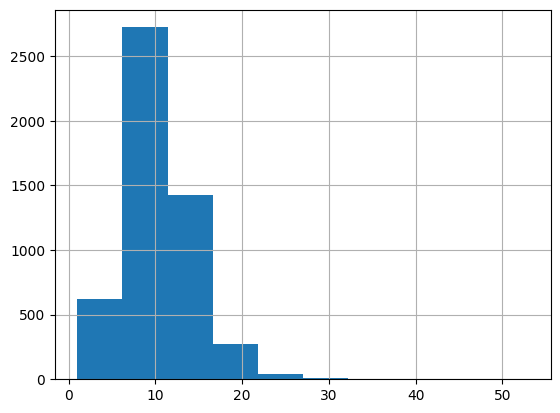

In [ ]:
print("Mediana:",df['cantidad_palabras_titulos'].median())
print("Media",df['cantidad_palabras_titulos'].mean())
df['cantidad_palabras_titulos'].hist()

In [ ]:
# Comprobación del balance de ese % de registros con mayor cantidad de palabras que el quantil especificado

cuantil = 0.50
sequence_length_titulos = int(df['cantidad_palabras_titulos'].quantile(cuantil))
print(f"Valor del cuantil {cuantil}: {sequence_length_titulos}")

# Se crea una columna con la cantidad de palabras de la columna cont_texto que hay en cada registro
df_noticias['cantidad_palabras_titulos'] = df['cantidad_palabras_titulos']

# Se filtra ese % de registros que tienen mayor cantidad de palabras
registros_mayor_cantidad_palabras_titulos = df_noticias[df_noticias['cantidad_palabras_titulos'] > sequence_length_titulos]

print(f"{len(registros_mayor_cantidad_palabras_titulos)} registros que se recorta su longitud")
display(registros_mayor_cantidad_palabras_titulos.groupby('real_fake').agg({'id_noticia':'count'}))

# Por último, se elimina la columna de apoyo, ya no hace falta
df_noticias.drop(columns='cantidad_palabras_titulos', inplace=True)

Valor del cuantil 0.5: 10
2302 registros que se recorta su longitud


,id_noticia
real_fake,
FAKE,991
REAL,1311


## Tokenización

### Textos

In [ ]:
# Tokenización
vectorize_layer_textos = TextVectorization(
    standardize="lower",
    max_tokens=max_features_textos,
    output_mode="int",
    output_sequence_length=sequence_length_textos,
)
vectorize_layer_textos.adapt(X_train['cont_texto'])


X_train_texto = vectorize_layer_textos(X_train['cont_texto'])
X_test_texto = vectorize_layer_textos(X_test['cont_texto'])


print(f"max_features {max_features_textos}")
print(f"sequence_length {sequence_length_textos}")

X_train_texto

max_features 10000
sequence_length 759


<tf.Tensor: shape=(5106, 759), dtype=int64, numpy=
array([[   2,  217,    9, ...,    0,    0,    0],
       [ 746,  409,  754, ...,    0,    0,    0],
       [  48,  184,  595, ...,    0,    0,    0],
       ...,
       [7491,  748,   29, ...,    0,    0,    0],
       [   1,    1,    6, ...,    0,    0,    0],
       [ 260,   25,   82, ...,    4,    2, 4076]])>

### Titulos

In [ ]:
# Tokenización
vectorize_layer_textos = TextVectorization(
    standardize="lower",
    max_tokens=max_features_titulos,
    output_mode="int",
    output_sequence_length=sequence_length_titulos,
)
vectorize_layer_textos.adapt(X_train['cont_titulo'])


X_train_titulo = vectorize_layer_textos(X_train['cont_titulo'])
X_test_titulo = vectorize_layer_textos(X_test['cont_titulo'])


print(f"max_features {max_features_titulos}")
print(f"sequence_length {sequence_length_titulos}")

X_train_titulo

max_features 2000
sequence_length 10


<tf.Tensor: shape=(5106, 10), dtype=int64, numpy=
array([[   2,   12,   45, ...,    0,    0,    0],
       [ 106,  287,  181, ...,    5,    2,   49],
       [1263,    1,    0, ...,    0,    0,    0],
       ...,
       [   2,    1,    1, ...,  238,   56,    1],
       [ 188,    1,   18, ...,  738,    1,    0],
       [  87,    1,  424, ...,   96,    1,   24]])>

In [ ]:
X_train_titulo_comprobacion = pd.DataFrame(X_train_titulo)
X_train_titulo_comprobacion.isna().sum().sum()

0

## Embedding

In [ ]:
embedding_dim = 100

### Textos

In [ ]:
# Crear la entrada del modelo
input_text = Input(shape=(sequence_length_textos,))  # Entrada basada en las secuencias tokenizadas. Cantidad de columnas que tienen los textos tokenizados.

# Añadir la capa de Embedding
embedding = Embedding(input_dim=max_features_textos, output_dim=embedding_dim, mask_zero=True)(input_text)

# Aplanar la salida de la capa de Embedding
# flatten = Flatten()(embedding) # Funciona mejor globar average pooling 1d
# Tambien se puede hacer con Globar average pooling1d
global_avg_pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding)

# Crear el modelo
embedding_model = Model(inputs=input_text, outputs=global_avg_pooling_layer)

embedding_train_texto = embedding_model(X_train_texto)
embedding_test_texto = embedding_model(X_test_texto)


### Titulos

In [ ]:
# Crear la entrada del modelo
input_text = Input(shape=(sequence_length_titulos,))  # Entrada basada en las secuencias tokenizadas. Cantidad de columnas que tienen los textos tokenizados.

# Añadir la capa de Embedding
embedding = Embedding(input_dim=max_features_titulos, output_dim=embedding_dim)(input_text) # Se quita el parámetro mask_zero=True porque genera secuencias con nulos al encontrar titulos que se han tokenizado como solo 0

# Aplanar la salida de la capa de Embedding
# flatten = Flatten()(embedding) # Funciona mejor globar average pooling 1d
# Tambien se puede hacer con Globar average pooling1d
global_avg_pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding)

# Crear el modelo
embedding_model = Model(inputs=input_text, outputs=global_avg_pooling_layer)

embedding_train_titulo = embedding_model(X_train_titulo)
embedding_test_titulo = embedding_model(X_test_titulo)

## Metricas

In [ ]:
# Se eliminan las columna 'cont_texto' y 'cont_titulo' que eran necesarias en el proceso de tokeniación
X_train_metricas = X_train.drop(columns=['cont_texto', 'cont_titulo'])
X_test_metricas = X_test.drop(columns=['cont_texto', 'cont_titulo'])
# X_train_metricas.columns.tolist()

In [ ]:
X_train_metricas.shape

(5106, 130)

## Normalización

In [ ]:
# Normalización
min_max_scaler = MinMaxScaler()
scaler = RobustScaler()
s_scaler = StandardScaler()

# Recordar solo normalizar datos de entrada, la salida se quiere predecir sin normalizar

X_train_metricas = scaler.fit_transform(X_train_metricas)
X_test_metricas = scaler.transform(X_test_metricas)

X_train_texto = scaler.fit_transform(X_train_texto )
X_test_texto = scaler.transform(X_test_texto )

X_train_titulo = scaler.fit_transform(X_train_titulo )
X_test_titulo = scaler.transform(X_test_titulo )

# Al normalizar, convierte los dataframe en arrays de numpy
print(type(X_train))


print(y_train)
y_train = (y_train.values).ravel()
y_test = (y_test.values).ravel()
y_train

<class 'pandas.core.frame.DataFrame'>
      real_fake
5607          0
3818          0
4102          0
2372          1
3072          0
...         ...
4030          0
2940          1
1334          1
1579          1
2775          1

[5106 rows x 1 columns]


array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
X_train_metricas

array([[-1.00978997, -0.115507  ,  1.4       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.23488843,  0.04958514,  1.9375    , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35849377, -0.36450331,  0.525     , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.55229046, -0.6495435 , -0.925     , ...,  0.        ,
         0.        ,  0.        ],
       [-0.74511973,  0.6547776 ,  0.50833333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66877273, -0.24249333, -0.56666667, ...,  0.        ,
         0.        ,  0.        ]])

# Guardado de los datos preprocesados

Para no tener que ejecutar de nuevo todo el preprocesamiento o preparación de los datos.

In [ ]:
# Crear un diccionario con todos los objetos
datos_preprocesados = {
    'max_features_textos':max_features_textos,
    'sequence_length_textos':sequence_length_textos,
    'max_features_titulos':max_features_titulos,
    'sequence_length_titulos':sequence_length_titulos,
    'X_train_metricas':X_train_metricas,
    'X_test_metricas':X_test_metricas,
    'X_train_texto':X_train_texto,
    'X_test_texto':X_test_texto,
    'X_train_titulo':X_train_titulo,
    'X_test_titulo':X_test_titulo,
    'y_train':y_train,
    'y_test':y_test,
    'embedding_train_texto':embedding_train_texto,
    'embedding_train_titulo':embedding_train_titulo,
    'embedding_test_texto':embedding_test_texto,
    'embedding_test_titulo':embedding_test_titulo
}

# Guardar el diccionario
with open('data/datos_preprocesados.pkl', 'wb') as f:
    joblib.dump(datos_preprocesados, f, compress=9) # Se usa compress para que comprima los datos lo que se traduce en un mayor tiempo de carga pero libera mucho espacio, 9 es el mayor nivel de compresion.

# Carga de datos preprocesados

In [ ]:
# Cargar el diccionario de preprocesamiento
with open('data/datos_preprocesados.pkl', 'rb') as f:
    datos_preprocesados = joblib.load(f)

# Esructura de los datos
print(f"Claves del diccionario datos_preprocesados: {datos_preprocesados.keys()}\n")

# Recuperar los objetos
max_features_textos = datos_preprocesados['max_features_textos']
sequence_length_textos = datos_preprocesados['sequence_length_textos']
max_features_titulos = datos_preprocesados['max_features_titulos']
sequence_length_titulos = datos_preprocesados['sequence_length_titulos']

X_train_metricas = datos_preprocesados['X_train_metricas']
X_test_metricas = datos_preprocesados['X_test_metricas']

X_train_texto = datos_preprocesados['X_train_texto']
X_test_texto = datos_preprocesados['X_test_texto']

X_train_titulo = datos_preprocesados['X_train_titulo']
X_test_titulo = datos_preprocesados['X_test_titulo']

y_train = datos_preprocesados['y_train']
y_test = datos_preprocesados['y_test']

embedding_train_texto = datos_preprocesados['embedding_train_texto']
embedding_train_titulo = datos_preprocesados['embedding_train_titulo']
embedding_test_texto = datos_preprocesados['embedding_test_texto']
embedding_test_titulo = datos_preprocesados['embedding_test_titulo']

# Comprobación dimensiones
print(type(X_train_texto))
print("X_train_metricas",X_train_metricas.shape)
print("X_test_metricas", X_test_metricas.shape)
print()
print("X_train_texto",X_train_texto.shape)
print("X_test_texto",X_test_texto.shape)
print()
print("X_train_titulo",X_train_titulo.shape)
print("X_test_titulo",X_test_titulo.shape)
# display(X_train)

Claves del diccionario datos_preprocesados: dict_keys(['max_features_textos', 'sequence_length_textos', 'max_features_titulos', 'sequence_length_titulos', 'X_train_metricas', 'X_test_metricas', 'X_train_texto', 'X_test_texto', 'X_train_titulo', 'X_test_titulo', 'y_train', 'y_test', 'embedding_train_texto', 'embedding_train_titulo', 'embedding_test_texto', 'embedding_test_titulo'])

<class 'numpy.ndarray'>
X_train_metricas (5106, 130)
X_test_metricas (902, 130)

X_train_texto (5106, 759)
X_test_texto (902, 759)

X_train_titulo (5106, 10)
X_test_titulo (902, 10)


# Selección de variables


In [ ]:
# Creación de listas donde se guardaran los valores de la precisión, TNR y recall de cada modelo
tabla_comparativa = pd.DataFrame()



# # # Titulos, textos y metricas
# SE ESTAN USANDO LOS TEXTOS TOKENIZADOS
# X_train = np.hstack([X_train_metricas, X_train_texto, X_train_titulo])
# X_test = np.hstack([X_test_metricas, X_test_texto, X_test_titulo])
# USANDO EMBEDDINGS
X_train = np.hstack([X_train_metricas, embedding_train_texto, embedding_train_titulo])
X_test = np.hstack([X_test_metricas, embedding_test_texto, embedding_test_titulo])


# # # Textos
# X_train = X_train_texto# tokenizado
# X_test = X_test_texto

# # # Titulos
# Ya existen X_train_titulo, tokenizado

# # # Metricas
# Ya existe X_train_metricas, tokenizado

# Titulos y textos
# X_train = np.hstack([X_train_texto, X_train_titulo])
# X_test = np.hstack([X_test_texto, X_test_titulo])

# # Titulos y metricas
# X_train = np.hstack([embedding_train_titulo, X_train_metricas])
# X_test = np.hstack([embedding_test_titulo, X_test_metricas])

# # Textos y metricas
# TOKENIZADOS
# X_train = np.hstack([X_train_texto, X_train_metricas])
# X_test = np.hstack([X_test_texto, X_test_metricas])
# EMBEDDING
# X_train = np.hstack([embedding_train_texto, X_train_metricas])
# X_test = np.hstack([embedding_test_texto, X_test_metricas])


print(X_train.shape)
print(X_train_texto.shape)
print(y_train.shape)

(5106, 330)
(5106, 759)
(5106,)


# Modelos Machine Learning

## Regresión logística

### Entrenamiento Regresión logísica

In [ ]:
# Tarda  min con embedding de textos y el resto de metricas

# Semilla establecida usando random_state de numpy, lo que permite que cada ejecución del código muestre el mismo resultado cada vez. random.seed() no funciona en los modelos.
# RandomState(42) # Se usa el parametro random_state de los modelos


tuned_parameters = {
    'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty':['l2'], # 'l1''l2', 'elasticnet' Se quitan estas penalizaciones pues entran en conflicto con algunos solver
}
nfolds = 5

reg_log = GridSearchCV(LogisticRegression(random_state=42), param_grid = tuned_parameters, cv = nfolds, return_train_score=True) #, error_score='raise'



# Entrenamiento con textos y métricas
reg_log.fit(X_train, y_train)


# Obtención del modelo (no se usa pues printea muchas variables, columnas en el dataframe)
# b0 = reg_log.intercept_
# betas = reg_log.coef_

# print("Y = ", end='')
# for i in range(len(X_train.columns)):
#     print(f"{np.round(reg_log.coef_[0][i],3)} {X_train.columns[i]}", end=' + ')
# print(np.round(reg_log.intercept_[0],2))
print(reg_log.best_params_)

{'penalty': 'l2', 'solver': 'sag'}


Aparece <font color='red'>ValueError: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty</font> aunque se ejecuta normalmente. Este error se debe a que el solver lbfgs no es compatible con la penalización l1 por ello se escoge la penalización L2 que es compatible con todos los solvers.  
Varios solver son incompatibles con ciertas penalizaciones.

### Guardado  y carga del modelo

In [ ]:
#---------------------------------- Guardado del modelo -----------------------------
joblib.dump(reg_log, 'models/reg_log_model.pkl')

['models/reg_log_model.pkl']

In [ ]:
#---------------------------------- Carga del modelo -----------------------------
reg_log = joblib.load('models/reg_log_model.pkl')

### Predicción y evaluación

In [ ]:
# Se calcula las predicciones con el grupo de train y con el de test
y_est = reg_log.predict(X_test)
y_est_train = reg_log.predict(X_train)



MAE_train = mean_absolute_error(y_train, y_est_train)
MSE_train = mean_squared_error(y_train, y_est_train)
accuracy_train = reg_log.score(X_train, y_train)
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall_train = recall_score(y_train, y_est_train)


modelo = 'Regresión logística'
MAE = mean_absolute_error(y_test, y_est)
MSE = mean_squared_error(y_test, y_est)
accuracy = reg_log.score(X_test, y_test)
tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall = recall_score(y_test, y_est)

# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy, 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)


print("----- TRAIN -----")
print(f"Error absoluto medio: {MAE_train}")
print(f"Error cuadrático medio: {MSE_train}")
print(f"PRECISIÓN: {accuracy_train}")
print(f"TNR: {tnr_train}")
print(f"RECALL: {recall_train}")

print()

print("----- TEST -----")
print(f"Error absoluto medio: {MAE}")
print(f"Error cuadrático medio: {MSE}")
print(f"PRECISIÓN: {accuracy}")
print(f"TNR: {tnr}")
print(f"RECALL: {recall}")

----- TRAIN -----
Error absoluto medio: 0.28123775949862906
Error cuadrático medio: 0.28123775949862906
PRECISIÓN: 0.7187622405013709
TNR: 0.5489428347689899
RECALL: 0.8887147335423198

----- TEST -----
Error absoluto medio: 0.3170731707317073
Error cuadrático medio: 0.3170731707317073
PRECISIÓN: 0.6829268292682927
TNR: 0.5543710021321961
RECALL: 0.8221709006928406


COMPROBAR RANDOM_STATE = 42 (Conclusión, el parámetro random_state funciona, devuelve el mismo resultado cada ejecución)  


### Matriz confusión

Confusion matrix
[[260 209]
 [ 77 356]]
Normalized confusion matrix
[[0.554371  0.445629 ]
 [0.1778291 0.8221709]]


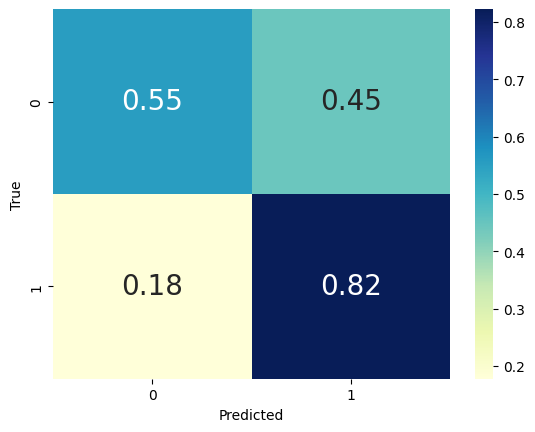

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### AUC

AUC:  0.7182743491385042


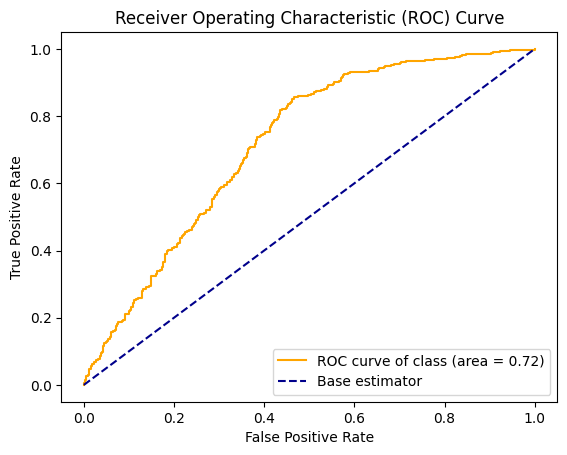

In [ ]:
# Gráfico de área bajo la curva AUC

fpr, tpr, thresholds = roc_curve(y_test, reg_log.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

## KNNeighbors

### Buscando los k vecinos óptimos

For K = 100, train accuracy is 65.45% and test accuracy is 59.20%


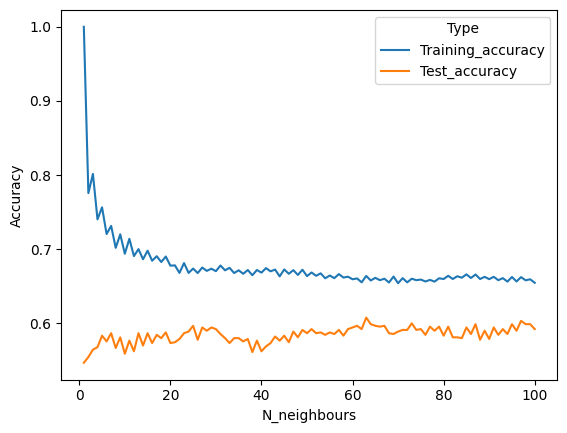

In [ ]:
# Tarda 2min 52s

K_max=100
rang_K = np.arange(1, K_max+1)
accs = pd.DataFrame(columns=["Neighbors","Training Accuracy", "Test Accuracy"])
accs_list = list()

for n_neighbors in rang_K:
    # Crear el modelo y entrenarlo
    knnModel_iter = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    # Obtener la precision para el conjunto de datos de entrenamiento y testeo
    acc_tr = knnModel_iter.score(X_train, y_train)
    acc_test = knnModel_iter.score(X_test, y_test)

    accs_list.append([n_neighbors, acc_tr,acc_test])

accs=pd.DataFrame(accs_list, columns=['N_neighbours','Training_accuracy','Test_accuracy'])

print("For K = %d, train accuracy is %2.2f%% and test accuracy is %2.2f%%"
        % (n_neighbors, 100*acc_tr, 100*acc_test))


# Mostremos la evolución de la precision
melted_accs = accs.melt('N_neighbours', var_name="Type", value_name="Accuracy")
g = sns.lineplot(x="N_neighbours", y="Accuracy", hue='Type', data=melted_accs)

In [ ]:
# # Df donde se almacena la información de todas las iteraciones
# melted_accs

### Entrenamiento de KNeighborsClassifier

In [ ]:
# KNeighborsClassifier no tiene parámetro random_state así que se usa RandomState de numpy
RandomState(42)

k_max = 70 # Número aproximado obtenido de la comprobación de los k vecimos óptimos anteriormente realizada
k_min = 20 # Número aproximado obtenido de la comprobación de los k vecimos óptimos anteriormente realizada
rang_K = np.arange(20, k_max+1, 5)
tuned_parameters = {
    'n_neighbors': rang_K}
nfold = 5


# Se define el modelo de clasificacion kNN
knnModel_CV = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=nfold, return_train_score=True).fit(X_train, y_train)


In [ ]:
knnModel_CV.best_params_

{'n_neighbors': 65}

### Guardado y carga del modelo

In [ ]:
#---------------------------------- Guardado del modelo -----------------------------
joblib.dump(knnModel_CV, 'models/knnModel_CV_model.pkl')

['models/knnModel_CV_model.pkl']

In [ ]:
#---------------------------------- Carga del modelo -----------------------------
knnModel_CV = joblib.load('models/knnModel_CV_model.pkl')

### Predicción y evaluación

In [ ]:
# Obtener el error cuadratico medio, la precision y la especificidad de test

y_est = knnModel_CV.predict(X_test)

modelo = 'KNNeighbors'
MSE_tst = mean_squared_error(y_est, y_test)
MAE_tst = mean_absolute_error(y_est, y_test)
accuracy = knnModel_CV.score(X_test, y_test)
tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall = recall_score(y_test, y_est)

# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy, 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

# Obtener el error cuadratico medio, la precision y la especificidad de train

y_est_train = knnModel_CV.predict(X_train)

MSE_tst_train = mean_squared_error(y_est_train, y_train)
MAE_tst_train = mean_absolute_error(y_est_train, y_train)
accuracy_train = knnModel_CV.score(X_train, y_train)
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall_train = recall_score(y_train, y_est_train)


# Se puede obtener el mejor parametro asi
K_CV = knnModel_CV.best_params_['n_neighbors']


# Se muestran los resultados
print('Selected value of k: ' + str(K_CV))
print("----- TRAIN -----")
print('MSE : ' + str(MSE_tst_train))
print('MAE : ' + str(MAE_tst_train))
print('Accuracy: ' + str(accuracy_train))
print('Specificity: ' + str(tnr_train))
print(f"Recall {recall_train}")

print("----- TEST -----")
print('MSE : ' + str(MSE_tst))
print('MAE : ' + str(MAE_tst))
print('Accuracy: ' + str(accuracy))
print('Specificity: ' + str(tnr))
print(f"Recall {recall}")

Selected value of k: 65
----- TRAIN -----
MSE : 0.33881707794751276
MAE : 0.33881707794751276
Accuracy: 0.6611829220524873
Specificity: 0.5732184808144087
Recall 0.7492163009404389
----- TEST -----
MSE : 0.4035476718403548
MAE : 0.4035476718403548
Accuracy: 0.5964523281596452
Specificity: 0.5330490405117271
Recall 0.6651270207852193


### Matriz de confusión

Confusion matrix
[[250 219]
 [145 288]]
Normalized confusion matrix
[[0.53304904 0.46695096]
 [0.33487298 0.66512702]]


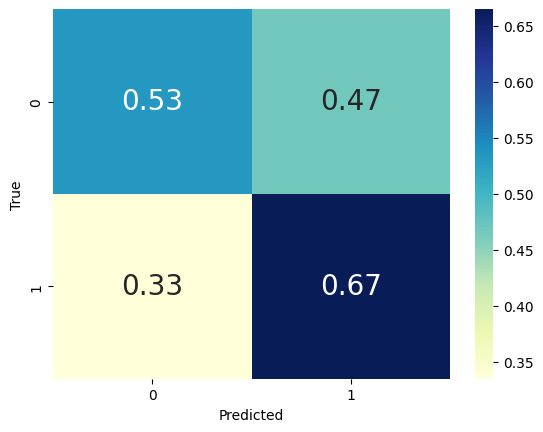

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### AUC

AUC:  0.6394372577889175


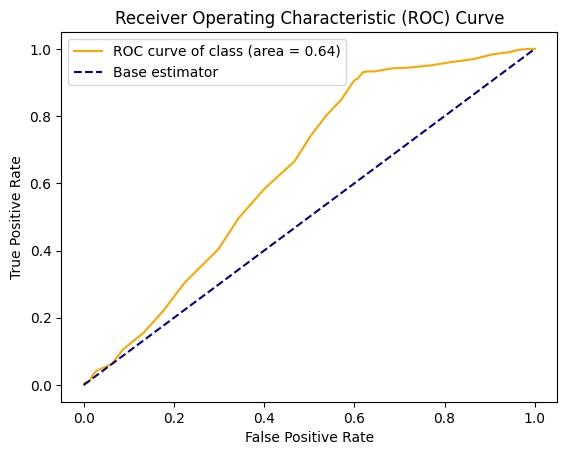

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, knnModel_CV.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

## Support Vector Machine  
Con SGDClassifier  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

### Entrenamiento de Support Vector Machine

In [ ]:
# Tarda 3 min

# Se calcula GridSearchCV para un support vector machine con los parámetros óptimos
# RandomState(42) # se usa random_state de los parámetros de los modelos


epsilon_rang = np.logspace(-3,1,3)
eta0_rang = np.logspace(-3,1,3)
alpha_rang = np.logspace(-3,1,3)

tuned_parameters = [{
    'alpha':alpha_rang,
    'eta0':eta0_rang,
    'epsilon':epsilon_rang,
    'loss':['hinge','squared_hinge'], # Ambos de SVM si se elige una perdida diferente ya no estamos hablando de support vector machine si no de otro tipo de modelos
    'penalty':['l2']
}]

svm_GS = GridSearchCV(SGDClassifier(random_state=42),tuned_parameters, cv=5, error_score='raise').fit(X_train, y_train)


### Guardado y carga del modelo

In [ ]:
#---------------------------------- Guardado del modelo -----------------------------
joblib.dump(svm_GS, 'models/svm_GS_model.pkl')

['models/svm_GS_model.pkl']

In [ ]:
#---------------------------------- Carga del modelo -----------------------------
svm_GS = joblib.load('models/svm_GS_model.pkl')

### Predicción y evaluación

In [ ]:
# Obtener el error cuadratico medio, la precision y la especificidad de test

y_est = svm_GS.predict(X_test)

modelo = "Suppor Vector Machine"
MSE_tst = mean_squared_error(y_est, y_test)
MAE_tst = mean_absolute_error(y_est, y_test)
accuracy = svm_GS.score(X_test, y_test)
tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall = recall_score(y_test, y_est)


# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy, 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

# Obtener el error cuadratico medio, la precision y la especificidad de train

y_est_train = svm_GS.predict(X_train)

MSE_tst_train = mean_squared_error(y_est_train, y_train)
MAE_tst_train = mean_absolute_error(y_est_train, y_train)
accuracy_train = svm_GS.score(X_train, y_train)
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall_train = recall_score(y_train, y_est_train)




# Se muestran los resultados

print(f"Parámetros óptimos {svm_GS.best_params_}")
# print(svm_GS.best_estimator_)
print(f"Mejor precisión{svm_GS.best_score_}")


print("----- TRAIN -----")
print('MSE : ' + str(MSE_tst_train))
print('MAE : ' + str(MAE_tst_train))
print('Accuracy: ' + str(accuracy_train))
print('Specificity: ' + str(tnr_train))
print(f"Recall {recall_train}")

print("----- TEST -----")
print('MSE : ' + str(MSE_tst))
print('MAE : ' + str(MAE_tst))
print('Accuracy: ' + str(accuracy))
print('Specificity: ' + str(tnr))
print(f"Recall {recall}")

Parámetros óptimos {'alpha': 0.001, 'epsilon': 0.001, 'eta0': 0.001, 'loss': 'squared_hinge', 'penalty': 'l2'}
Mejor precisión0.7275780047572409
----- TRAIN -----
MSE : 0.26145710928319627
MAE : 0.26145710928319627
Accuracy: 0.7385428907168038
Specificity: 0.7286609240407205
Recall 0.7484326018808778
----- TEST -----
MSE : 0.26940133037694014
MAE : 0.26940133037694014
Accuracy: 0.7305986696230599
Specificity: 0.7334754797441365
Recall 0.7274826789838337


### Matriz de confusión

Confusion matrix
[[344 125]
 [118 315]]
Normalized confusion matrix
[[0.73347548 0.26652452]
 [0.27251732 0.72748268]]


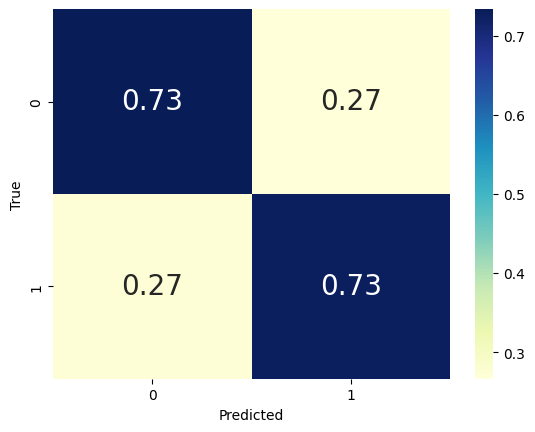

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### AUC

AUC:  0.7304790793639852


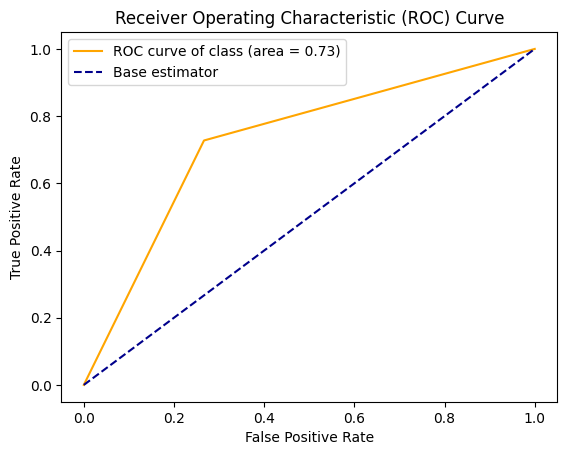

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, svm_GS.predict(X_test))
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

AttributeError: probability estimates are not available for loss='hinge'

## Árbol de decisión

In [ ]:
# Qué parámetros probar en min_samples_leaf y min_samples_split, fuente https://stackoverflow.com/questions/67532613/how-to-define-min-sample-split-and-min-sample-leaf-in-decision-tree-regresso

### Entrenamiendo de árbol de decisión

In [ ]:
# Búsqueda de los mejores parámetros
# RandomState(0) # En su lugar se usa random_state en los parámetros del modelo

# max_depth cuanto menor sea, menos sobreaprende el árbol de decisión
# np.logspace(-3,-1,4)
# np.linspace(0.01, 0.03, 4)
rang_split = np.logspace(-3,-2,4)
rang_samples = np.logspace(-3,-1,4)
rang_depth = np.arange(3,7)
tuned_parameters=[{'criterion':['gini','entropy','log_loss'],
                    'max_depth':rang_depth,
                    'min_samples_leaf':rang_samples,
                    'min_samples_split':rang_split
                    }]
nfolds=5

tree_CV = GridSearchCV(DecisionTreeClassifier(random_state=42), tuned_parameters, cv=nfolds,error_score='raise').fit(X_train, y_train)
# No se usa return_train_score=False por motivos de optimización del tiempo de ejecución


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
tree_CV.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 0.004641588833612777,
 'min_samples_split': 0.01}

### Guardado y carga del modelo

In [ ]:
#---------------------------------- Guardado del modelo -----------------------------
joblib.dump(tree_CV, 'models/tree_CV_model.pkl')

['models/tree_CV_model.pkl']

In [ ]:
#---------------------------------- Carga del modelo -----------------------------
tree_CV = joblib.load('models/tree_CV_model.pkl')

### Predicción y evaluación

In [ ]:
# Obtener el error cuadratico medio, la precision y la especificidad de test

y_est = tree_CV.predict(X_test)

modelo = "Árbol de decisión"
MSE_tst = mean_squared_error(y_est, y_test)
MAE_tst = mean_absolute_error(y_est, y_test)
accuracy = tree_CV.score(X_test, y_test)
tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall = recall_score(y_test, y_est)

# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy, 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

# Obtener el error cuadratico medio, la precision y la especificidad de train

y_est_train = tree_CV.predict(X_train)


MSE_tst_train = mean_squared_error(y_est_train, y_train)
MAE_tst_train = mean_absolute_error(y_est_train, y_train)
accuracy_train = tree_CV.score(X_train, y_train)
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall_train = recall_score(y_train, y_est_train)




# Se muestran los resultados

print(f"Parámetros óptimos {tree_CV.best_params_}")
# print(svm_GS.best_estimator_)
print(f"Mejor precisión{tree_CV.best_score_}")


print("----- TRAIN -----")
print('MSE : ' + str(MSE_tst_train))
print('MAE : ' + str(MAE_tst_train))
print('Accuracy: ' + str(accuracy_train))
print('Specificity: ' + str(tnr_train))
print(f"Recall {recall_train}")

print("----- TEST -----")
print('MSE : ' + str(MSE_tst))
print('MAE : ' + str(MAE_tst))
print('Accuracy: ' + str(accuracy))
print('Specificity: ' + str(tnr))
print(f"Recall {recall}")

Parámetros óptimos {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 0.004641588833612777, 'min_samples_split': 0.01}
Mejor precisión0.7546041925820011
----- TRAIN -----
MSE : 0.19428123775949863
MAE : 0.19428123775949863
Accuracy: 0.8057187622405013
Specificity: 0.7529365700861393
Recall 0.8585423197492164
----- TEST -----
MSE : 0.27827050997782704
MAE : 0.27827050997782704
Accuracy: 0.7217294900221729
Specificity: 0.673773987206823
Recall 0.7736720554272517


In [ ]:
# tree_CV.cv_results_['params']

In [ ]:
# print(tree_CV.cv_results_.keys())

### Matriz de confusión

Confusion matrix
[[316 153]
 [ 98 335]]
Normalized confusion matrix
[[0.67377399 0.32622601]
 [0.22632794 0.77367206]]


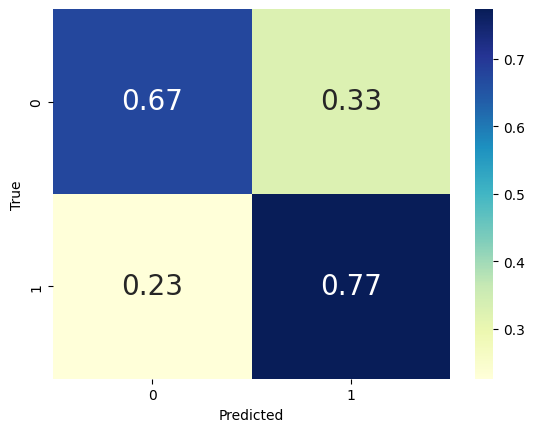

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### AUC

AUC:  0.8055762100090114


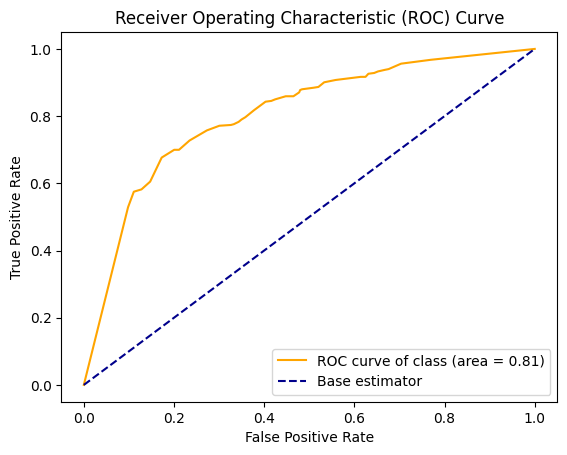

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,tree_CV.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

In [ ]:
# # Para ver la variable que tiene más importancia en el modelo
# # Este código funciona cuando los datos de entrada estan en formato DataFrame

# indice = pd.DataFrame(tree.feature_importances_).idxmax()
# X_train.columns[indice]

### Plot_tree

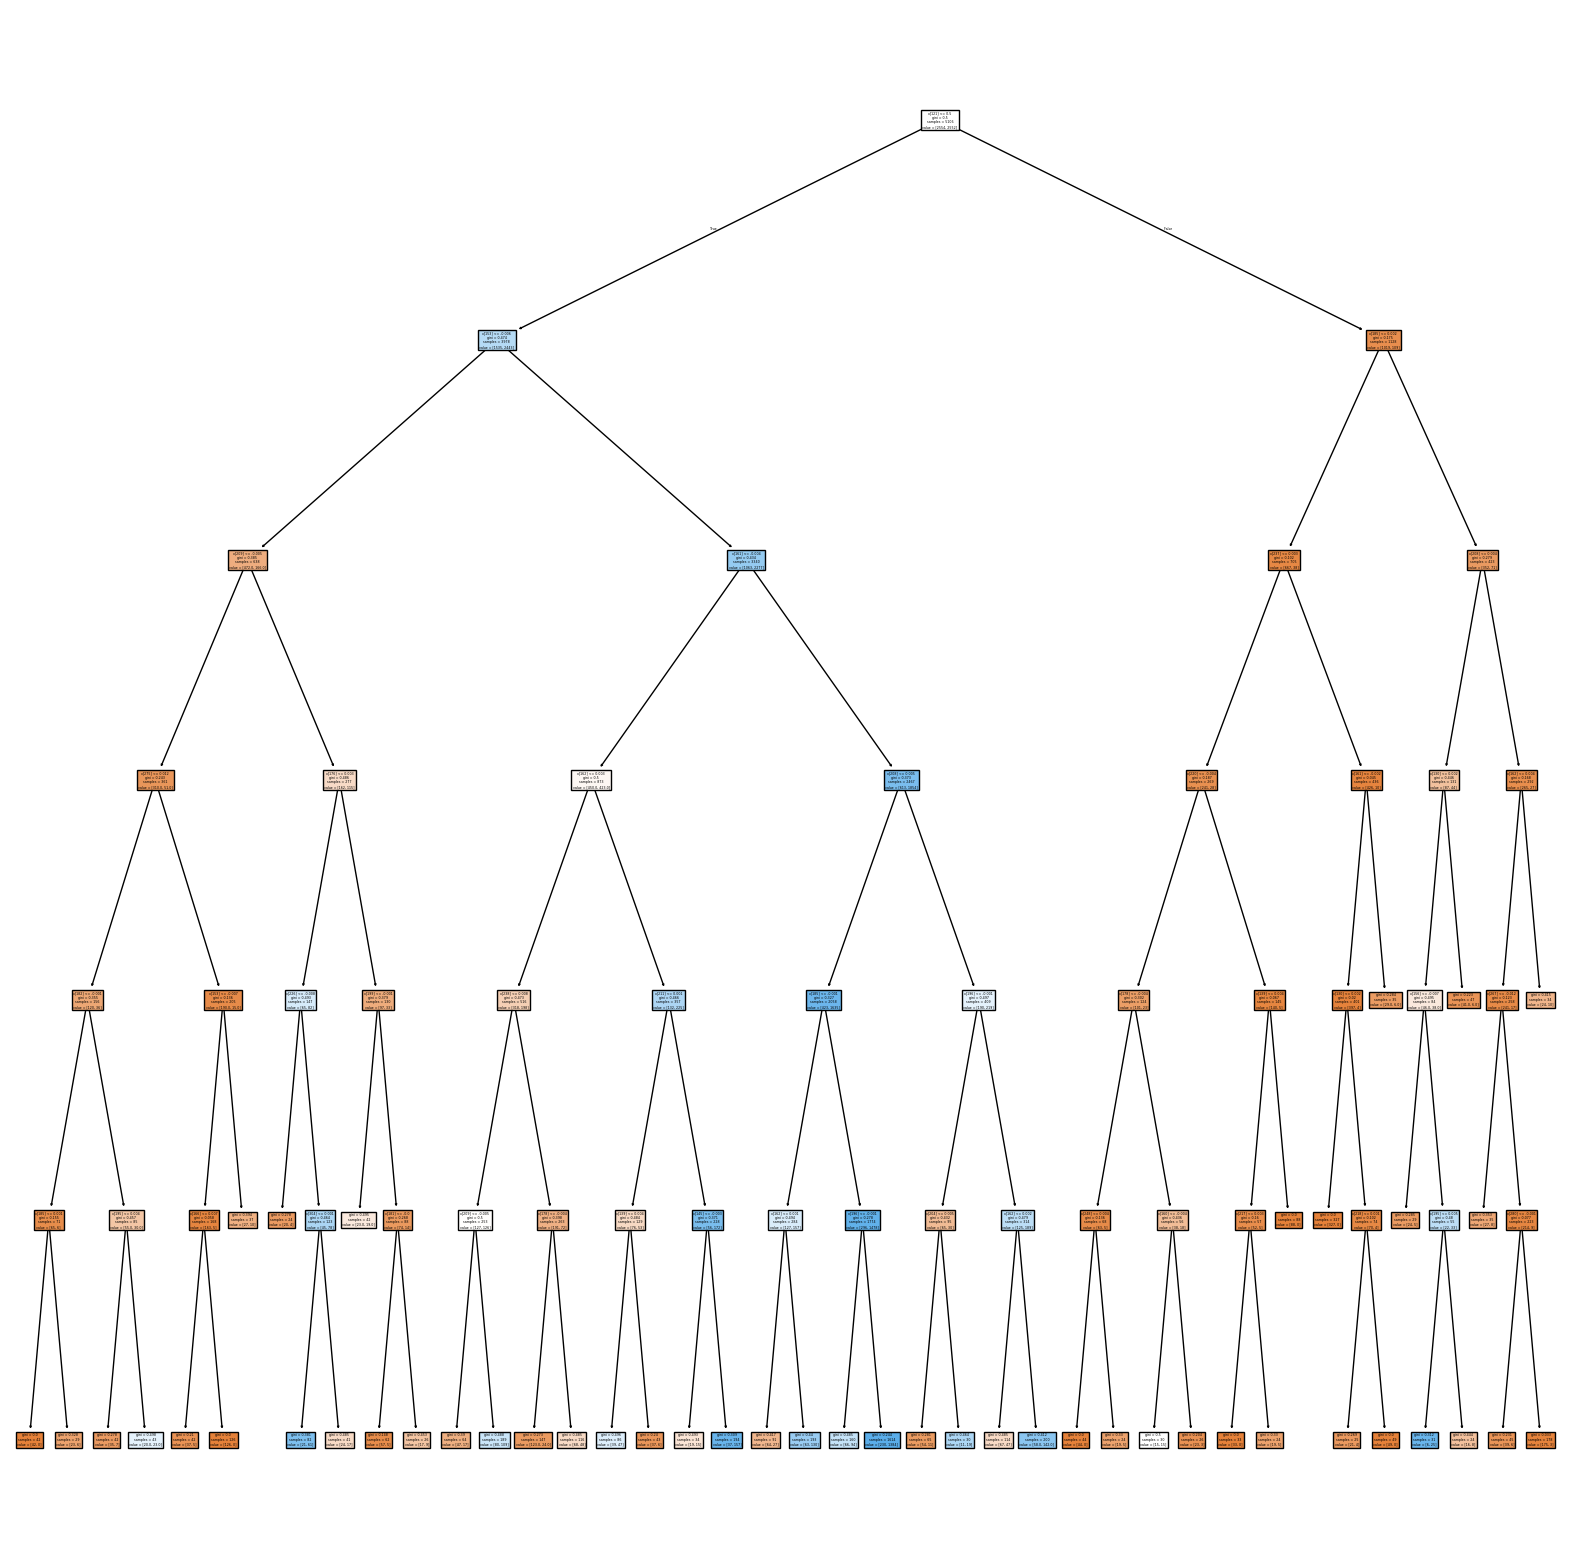

In [ ]:
plt.figure(figsize=(20, 20))
plot_tree(tree_CV.best_estimator_, filled=True) # , feature_names=X_train.columns
plt.show()

In [ ]:
# NO SE PUEDE METER EN EL ESTIMATOR DE UN BAGGING UN MODELO YA ENTRENADO, ESTE CÓDIGO ESTA MAL
# Ensamble con 30 árboles de decisión
# bagging_tree = BaggingClassifier(grid_tree, n_estimators = 30, max_samples=.5, max_features=.5, oob_score=True).fit(X_train , y_train)

# y_est = bagging_tree.predict(X_test)

# print("Accuracy",bagging_tree.score(X_test, y_test))
# print("MSE",mean_squared_error(y_est, y_test))
# bagging_tree.estimators_[0].best_estimator_

# Algoritmos avanzados: Emsemblers

## Bagging con tocones

### Entrenamiento

In [ ]:
tocones = BaggingClassifier(DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=10, max_features=.5, max_samples=.5, random_state=42).fit(X_train, y_train)

accuracy = tocones.score(X_test, y_test)

y_est = tocones.predict(X_test)

modelo = "Bagging de tocones"
tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall = recall_score(y_test, y_est)


# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy, 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)


print(f"Precision {accuracy}")
print(F"MSE {mean_squared_error(y_test, y_est)}")
print(f"True Negative Rate {tnr}")
print(f"Recall {recall}")


Precision 0.7062084257206208
MSE 0.29379157427937913
True Negative Rate 0.5330490405117271
Recall 0.8937644341801386


### Guardado y carga del modelo

In [ ]:
#---------------------------------- Guardado del modelo -----------------------------
joblib.dump(tocones, 'models/tocones_model.pkl')

['models/tocones_model.pkl']

In [ ]:
#---------------------------------- Carga del modelo -----------------------------
tocones = joblib.load('models/tocones_model.pkl')

### Matriz de confusión

Confusion matrix
[[250 219]
 [ 46 387]]
Normalized confusion matrix
[[0.53304904 0.46695096]
 [0.10623557 0.89376443]]


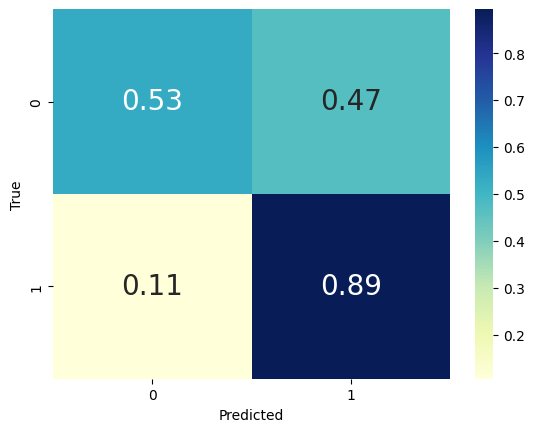

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis] # Aqui esta calculando el recall TPR y la especificidad TNR
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### AUC

AUC:  0.8050690132314344


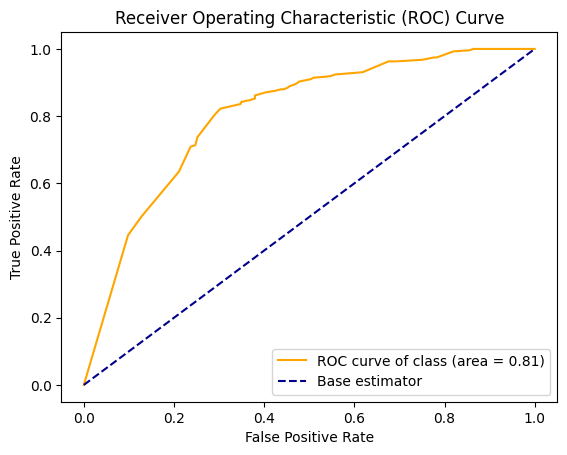

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,tocones.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

## Random Forest

In [ ]:
# Cantidad de variables que se escogen en los nodos
print(X_train.shape[1])

variables = int((X_train.shape[1])**(0.5))
print(variables)

330
18


https://stackoverflow.com/questions/44683253/bagging-with-decision-stumps-in-sklearn-how-to-view-the-results

### Entrenamiento de RandomForestClassifier

In [ ]:
print(np.logspace(-3,-2,3))

print(np.linspace(0.01, 0.03, 3))

[0.001      0.00316228 0.01      ]
[0.01 0.02 0.03]


[Enlace de referencia de parámetros óptimos para random forest](https://datascience.stackexchange.com/questions/111833/how-and-what-parameter-to-choose-for-a-random-forest-classifier)  


In [ ]:
# RandomState(42)

rang_split = np.logspace(-3,-2,4)
# rang_samples = np.linspace(0.01, 0.03, 4)
depth = np.arange(4,8)
# n_estimators = np.arange(1,21)
features=['sqrt','log2']
criterion=['gini','entropy','log_loss']

tuned_parameters=[{
    # 'n_estimators': [100,150,200],
    'max_depth':depth,
    'max_features':features,
    'criterion':criterion,
    # 'min_samples_leaf':rang_samples,
    'min_samples_split':rang_split
}]

# tuned_parameters=[{
#     'n_estimators': [100,150,200],
#     'max_features': ['sqrt','log2'],
#     'max_depth' : [4,5,6,7],
#     'min_samples_split' :[2,3,4,5,6],
#     'max_samples': [100,150,200,250]
# }]



r_forest = GridSearchCV(RandomForestClassifier(random_state=42), tuned_parameters, error_score='raise').fit(X_train, y_train)


In [ ]:
r_forest.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 0.001}

### Guardado y carga del modelo

In [ ]:
#---------------------------------- Guardado del modelo -----------------------------
joblib.dump(r_forest, 'models/r_forest_model.pkl')

['models/r_forest_model.pkl']

In [ ]:
#---------------------------------- Carga del modelo -----------------------------
r_forest = joblib.load('models/r_forest_model.pkl')

### Predicción y evaluación

In [ ]:
# Obtener el error cuadratico medio, la precision y la especificidad de test

y_est = r_forest.predict(X_test)

modelo = "RandomForest"
MSE_tst = mean_squared_error(y_est, y_test)
MAE_tst = mean_absolute_error(y_est, y_test)
accuracy = r_forest.score(X_test, y_test)
tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall = recall_score(y_test, y_est)


# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy, 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

# Obtener el error cuadratico medio, la precision y la especificidad de train

y_est_train = r_forest.predict(X_train)

MSE_tst_train = mean_squared_error(y_est_train, y_train)
MAE_tst_train = mean_absolute_error(y_est_train, y_train)
accuracy_train = r_forest.score(X_train, y_train)
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall_train = recall_score(y_train, y_est_train)




# Se muestran los resultados

print(f"Parámetros óptimos {r_forest.best_params_}")
# print(svm_GS.best_estimator_)
print(f"Mejor precisión {r_forest.best_score_}")


print("----- TRAIN -----")
print('MSE : ' + str(MSE_tst_train))
print('MAE : ' + str(MAE_tst_train))
print('Accuracy: ' + str(accuracy_train))
print('Specificity: ' + str(tnr_train))
print(f"Recall {recall_train}")

print("----- TEST -----")
print('MSE : ' + str(MSE_tst))
print('MAE : ' + str(MAE_tst))
print('Accuracy: ' + str(accuracy))
print('Specificity: ' + str(tnr))
print(f"Recall {recall}")

Parámetros óptimos {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 0.001}
Mejor precisión 0.7998470476164921
----- TRAIN -----
MSE : 0.12593027810419113
MAE : 0.12593027810419113
Accuracy: 0.8740697218958089
Specificity: 0.8022709475332811
Recall 0.9459247648902821
----- TEST -----
MSE : 0.22062084257206208
MAE : 0.22062084257206208
Accuracy: 0.779379157427938
Specificity: 0.7590618336886994
Recall 0.8013856812933026


### Matriz de confusión

Confusion matrix
[[356 113]
 [ 86 347]]
Normalized confusion matrix
[[0.75906183 0.24093817]
 [0.19861432 0.80138568]]


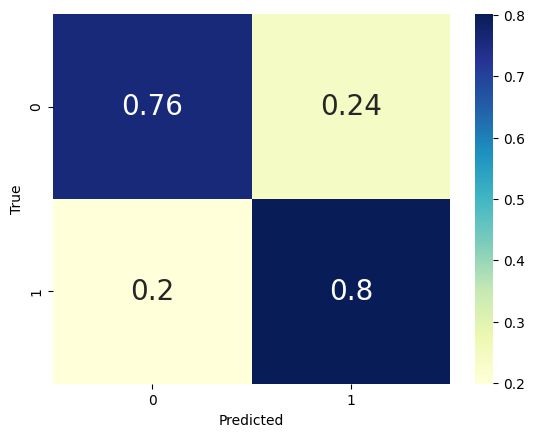

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis] # Aqui esta calculando el recall TPR y la especificidad TNR
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### AUC

AUC:  0.8588958867818611


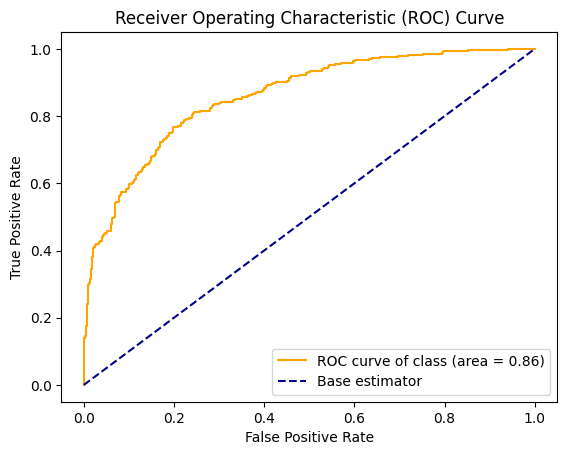

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,r_forest.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

In [ ]:
# dtype = pd.CategoricalDtype(['False Positive','True prediction','False Negative'])
# test_data = X_test[["visitas", "compartir"]].assign(Prediction=pd.Categorical.from_codes(codes=(y_test.values-y_est+1).astype(int), dtype=dtype))

# plt.figure(figsize=(9,6))
# g = sns.scatterplot(x="visitas", y="compartir", hue='Prediction', palette='mako', data=test_data, s=100)

In [ ]:
# help(plot_tree)

## Bagging con DecisionTreeClassifer

### Entrenamiento de Bagging de árboles de decisión

In [ ]:
# Entrenar y evaluar

# n_estimators = np.arange(1,21)
n_estimators = [100, 150, 200]


tuned_parameters=[{
    'n_estimators': n_estimators,

}]
bagging_tree = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42, max_depth=6), max_features=0.5, max_samples=0.5, random_state=42), tuned_parameters).fit(X_train , y_train)


In [ ]:
bagging_tree.best_params_

{'n_estimators': 150}

Se usa max_depth = 5 . Cuanto mayor sea la profundidad del arbol más sobre aprende el modelo.  
Limitar la profundidad se le llama poda, es una técnica para evitar que el modelo no generalice bien, es decir, que sobre aprenda.

### Guardado y carga del modelo

In [ ]:
#---------------------------------- Guardado del modelo -----------------------------
joblib.dump(bagging_tree, 'models/bagging_tree_model.pkl')

['models/bagging_tree_model.pkl']

In [ ]:
#---------------------------------- Carga del modelo -----------------------------
bagging_tree = joblib.load('models/bagging_tree_model.pkl')

### Predicción y evaluación

In [ ]:
# Obtener el error cuadratico medio, la precision y la especificidad de test

y_est = bagging_tree.predict(X_test)

modelo = "Bagging de árboles"
MSE_tst = mean_squared_error(y_est, y_test)
MAE_tst = mean_absolute_error(y_est, y_test)
accuracy = bagging_tree.score(X_test, y_test)
tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall = recall_score(y_test, y_est)

# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy, 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

# Obtener el error cuadratico medio, la precision y la especificidad de train

y_est_train = bagging_tree.predict(X_train)

MSE_tst_train = mean_squared_error(y_est_train, y_train)
MAE_tst_train = mean_absolute_error(y_est_train, y_train)
accuracy_train = bagging_tree.score(X_train, y_train)
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
recall_train = recall_score(y_train, y_est_train)




# Se muestran los resultados

print(f"Parámetros óptimos {bagging_tree.best_params_}")
# print(svm_GS.best_estimator_)
print(f"Mejor precisión {bagging_tree.best_score_}")


print("----- TRAIN -----")
print('MSE : ' + str(MSE_tst_train))
print('MAE : ' + str(MAE_tst_train))
print('Accuracy: ' + str(accuracy_train))
print('Specificity: ' + str(tnr_train))
print(f"Recall {recall_train}")

print("----- TEST -----")
print('MSE : ' + str(MSE_tst))
print('MAE : ' + str(MAE_tst))
print('Accuracy: ' + str(accuracy))
print('Specificity: ' + str(tnr))
print(f"Recall {recall}")

Parámetros óptimos {'n_estimators': 150}
Mejor precisión 0.8041555897579403
----- TRAIN -----
MSE : 0.14022718370544457
MAE : 0.14022718370544457
Accuracy: 0.8597728162945554
Specificity: 0.8022709475332811
Recall 0.917319749216301
----- TEST -----
MSE : 0.21507760532150777
MAE : 0.21507760532150777
Accuracy: 0.7849223946784922
Specificity: 0.7782515991471215
Recall 0.792147806004619


In [ ]:
# dtype = pd.CategoricalDtype(['False Positive','True prediction','False Negative'])
# test_data = X_test[["visitas", "compartir"]].assign(Prediction=pd.Categorical.from_codes(codes=(y_test.values-y_est+1).astype(int), dtype=dtype))

# plt.figure(figsize=(9,6))
# g = sns.scatterplot(x="visitas", y="compartir", hue='Prediction', palette='mako', data=test_data, s=100)

### Matriz de confusión

In [ ]:
# test_data

Confusion matrix
[[365 104]
 [ 90 343]]
Normalized confusion matrix
[[0.7782516  0.2217484 ]
 [0.20785219 0.79214781]]


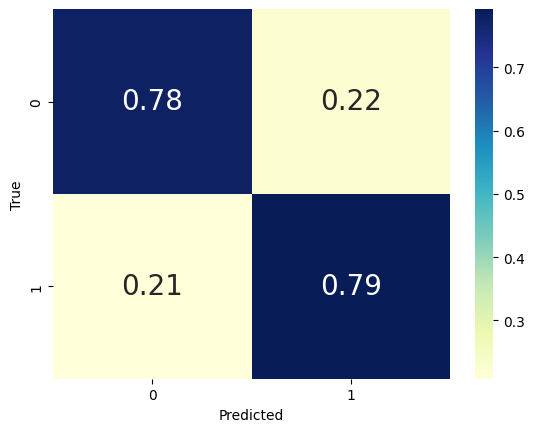

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis] # Aqui esta calculando el recall TPR y la especificidad TNR
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### AUC

AUC:  0.862589067201111


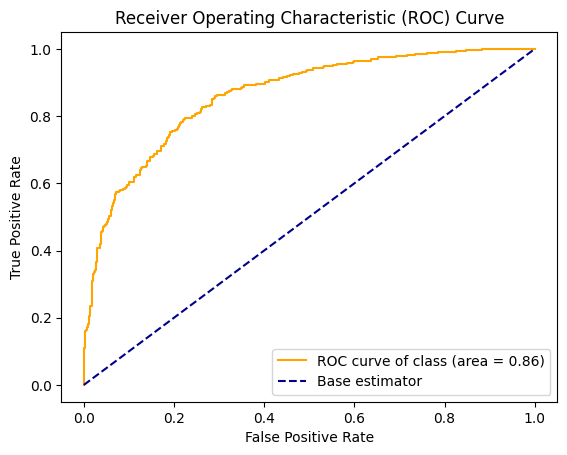

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,bagging_tree.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

In [ ]:
# n_nodes = bagging_tree.estimators_[1].tree_.node_count
# children_left = bagging_tree.estimators_[1].tree_.children_left
# children_right = bagging_tree.estimators_[1].tree_.children_right
# feature = bagging_tree.estimators_[1].tree_.feature
# threshold = bagging_tree.estimators_[1].tree_.threshold
# values = bagging_tree.estimators_[1].tree_.value

# # print(n_nodes, children_left, children_right, feature, threshold, values, sep='\n\n')
# node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
# is_leaves = np.zeros(shape=n_nodes, dtype=bool)
# stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
# while len(stack) > 0:
#     # `pop` ensures each node is only visited once
#     node_id, depth = stack.pop()
#     node_depth[node_id] = depth

#     # If the left and right child of a node is not the same we have a split
#     # node
#     is_split_node = children_left[node_id] != children_right[node_id]
#     # If a split node, append left and right children and depth to `stack`
#     # so we can loop through them
#     if is_split_node:
#         stack.append((children_left[node_id], depth + 1))
#         stack.append((children_right[node_id], depth + 1))
#     else:
#         is_leaves[node_id] = True

# print(
#     "The binary tree structure has {n} nodes and has "
#     "the following tree structure:\n".format(n=n_nodes)
# )
# for i in range(n_nodes):
#     if is_leaves[i]:
#         print(
#             "{space}node={node} is a leaf node with value={value}.".format(
#                 space=node_depth[i] * "\t", node=i, value=values[i]
#             )
#         )
#     else:
#         print(
#             "{space}node={node} is a split node with value={value}: "
#             "go to node {left} if X[:, {feature}] <= {threshold} "
#             "else to node {right}.".format(
#                 space=node_depth[i] * "\t",
#                 node=i,
#                 left=children_left[i],
#                 feature=feature[i],
#                 threshold=threshold[i],
#                 right=children_right[i],
#                 value=values[i],
#             )
#         )

In [ ]:
# from sklearn import tree

# for col in range(len(bagging_tree.estimators_)):
#     fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize=(20,20)) # estimators_[0]
#     tree.plot_tree(bagging_tree.estimators_[col],
#                     feature_names = X_train.columns,
#                     filled=True)
#     plt.show()

# Redes neuronales

## Clasificación con RNN solo con textos
Red neuronal recurrente

[Información sacada de la documentación](https://www.tensorflow.org/tutorials/keras/text_classification?hl=es-419#train_the_model)

https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=es-419#train_the_model

In [ ]:
RandomState(42)

RandomState(MT19937) at 0x788B821A8B40

### Arquitectura y entrenamiento

In [ ]:
embedding_dim = 100 # tambien se puede usar 150,200,300
print(f"Longitud palabras {sequence_length_textos}")
print(f"Longitud vocabulario {max_features_textos}")
print(f"Dimensión del embedding {embedding_dim}")

Longitud palabras 759
Longitud vocabulario 10000
Dimensión del embedding 100


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        max_features_textos,
        embedding_dim,
        # input_length=sequence_length_textos,
        # Use masking to handle the variable sequence lengths
        # mask_zero=True
        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.001))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, kernel_regularizer=keras.regularizers.l2(0.001))),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation="sigmoid")
])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(), #from_logits=True
              optimizer=tf.keras.optimizers.SGD(0.01),
              metrics=['accuracy','TrueNegatives', 'FalsePositives','AUC'])

callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), # Permite parar la ejecución antes del máximo de epochs monitorizando la perdida del conjunto de validación y parando la ejecución cuando deje de disminuir a lo largo de 5 epochs.
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-6), # Cuando la pérdida del conjunto de validación deje de disminuir a lo largo de  epochs, reduce un 0.1 por ciento el learning rate llegando a un 1e-6 de mínimo.
    tf.keras.callbacks.ModelCheckpoint(filepath='models/checkpoint_rnn_model.keras',
    monitor='val_loss', save_best_only=True, verbose=1) # Guarda el epoch con mejores valores durante el entrenamiento
]


history = model.fit(X_train_texto, y_train, epochs=30, batch_size=64,
                    validation_data=(X_test_texto, y_test),
                    callbacks=callbacks)

model.summary()

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - AUC: 0.6024 - FalsePositives: 500.5750 - TrueNegatives: 804.9875 - accuracy: 0.5804 - loss: 1.7805
Epoch 1: val_loss improved from inf to 1.70830, saving model to models/checkpoint_rnn_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - AUC: 0.6025 - FalsePositives: 506.3210 - TrueNegatives: 814.6543 - accuracy: 0.5805 - loss: 1.7802 - val_AUC: 0.6649 - val_FalsePositives: 0.0000e+00 - val_TrueNegatives: 469.0000 - val_accuracy: 0.5200 - val_loss: 1.7083
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - AUC: 0.6198 - FalsePositives: 488.2500 - TrueNegatives: 817.3125 - accuracy: 0.5923 - loss: 1.7230
Epoch 2: val_loss improved from 1.70830 to 1.70546, saving model to models/checkpoint_rnn_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - AUC: 0.6200 - FalsePositives: 494.0864 - TrueNegatives: 826.8889 - accuracy: 0.5924 - loss: 1.7229 - val_AUC: 0.6638 - val_FalsePositives: 0.0000e+00 - val_TrueNegatives: 469.0000 - va

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 759, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 759, 100)            │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 759, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,671,123 (6.37 MB)

 Trainable params: 1,670,537 (6.37 MB)

 Non-trainable params: 584 (2.28 KB)

 Optimizer params: 2 (12.00 B)

### Guardado y carga del modelo

In [ ]:
# # ----------- Carga checkpoint
# model = tf.keras.models.load_model("models/rnn_textos_model.keras")

In [ ]:
# --------------- Guardar modelo ----------------
model.save('models/rnn_textos_model.keras')
# keras.saving.save_model(model, "models/rnn_textos_model.keras.zip")

In [ ]:
# --------------- Cargar modelo ----------------
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
model = tf.keras.models.load_model("models/rnn_textos_model.keras")

### Predicción y evaluación

In [ ]:
accuracy_train = model.evaluate(X_train_texto, y_train, return_dict=True)
accuracy = model.evaluate(X_test_texto, y_test, return_dict=True)

modelo = "Red neuronal recurrente solo textos"


print(accuracy_train['accuracy'], accuracy['accuracy'])

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - AUC: 0.7404 - FalsePositives: 305.1988 - TrueNegatives: 985.3292 - accuracy: 0.6710 - loss: 1.5182
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - AUC: 0.6888 - FalsePositives: 66.9667 - TrueNegatives: 188.8667 - accuracy: 0.6542 - loss: 1.5660
0.6692126989364624 0.6496673822402954


In [ ]:
# TNR = history.history['true_negatives'][0] / (history.history['false_positives'][0] + history.history['false_positives'][0]) esto no funciona

y_est = np.round(model.predict(X_test_texto))
y_est_train = np.round(model.predict(X_train_texto))


tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR

recall = recall_score(y_test, y_est)
recall_train = recall_score(y_train, y_est_train)


# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy['accuracy'], 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

print("TNR TRAIN",tnr_train)
print("TNR TEST",tnr)
print("recall TRAIN",recall_train)
print("recall TEST", recall)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
TNR TRAIN 0.7607674236491777
TNR TEST 0.7398720682302772
recall TRAIN 0.5775862068965517
recall TEST 0.5519630484988453


dict_keys(['AUC', 'FalsePositives', 'TrueNegatives', 'accuracy', 'loss', 'val_AUC', 'val_FalsePositives', 'val_TrueNegatives', 'val_accuracy', 'val_loss'])


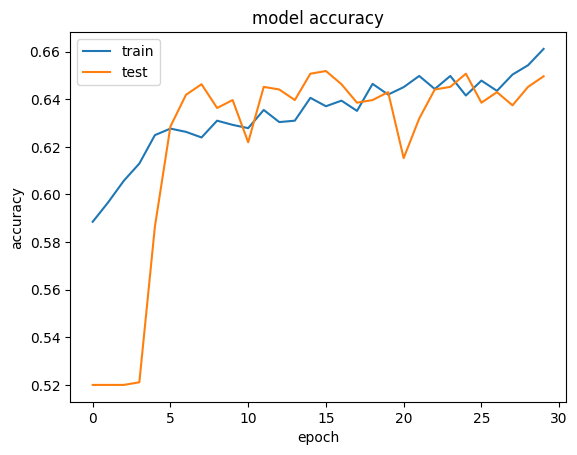

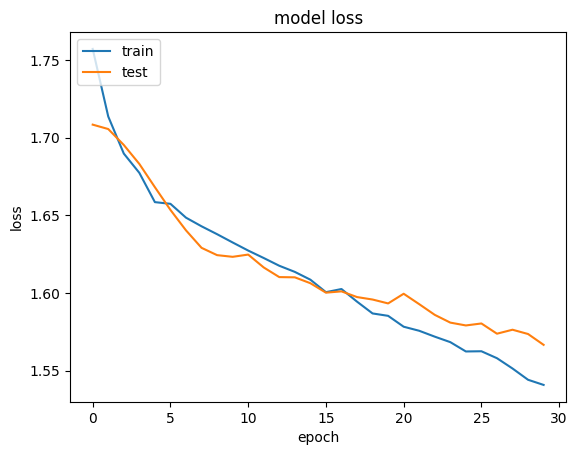

In [ ]:
print(history.history.keys())
# Precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Matriz confusión

Confusion matrix
[[347 122]
 [194 239]]
Normalized confusion matrix
[[0.73987207 0.26012793]
 [0.44803695 0.55196305]]


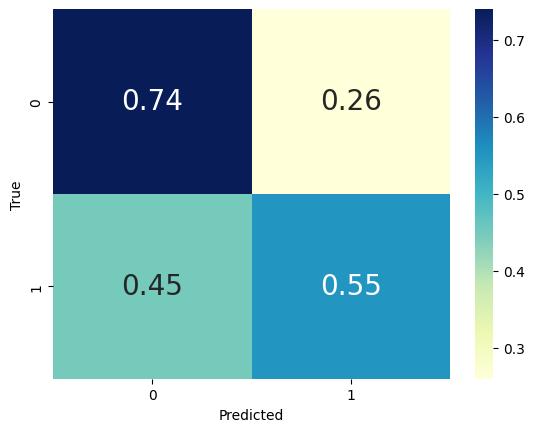

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

### AUC

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
AUC:  0.6868379974098494


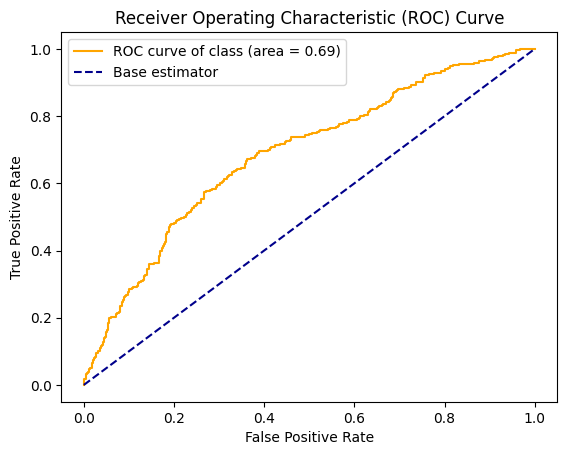

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test_texto))
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

## Antiguo encoder capas personalizadas. No se puede usar aún.  
No se puede guardar sin serializar las capas personalizadas antes.  
No es un transformer en su totalidad, se usa la parte de encoder (capa de atención, add & norm más capa feed forward otra add & norm), capa de atención cruzada y feedforward junto con una capa final dense y finalmente una softmax o sigmoide (para una clasificación binaria sería suficiente usar una sigmoide)


<img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>

### Definición de las capas del encoder  
con clases personalizadas

In [ ]:
# # Parámetros
# embedding_dim = 100

# print(f"max_features {max_features_textos}") # Las x palabras con mas frecuencia en los textos
# print(f"sequence_length {sequence_length_textos}") # Longitud de los textos
# print(f"embedding_dim {embedding_dim}")

max_features 10000
sequence_length 759
embedding_dim 100


In [ ]:
# # -------- Positional encoding -----------
# # genera el vector posicional
# def positional_encoding(length, depth):
#   depth = depth/2
#   positions = np.arange(length)[:, np.newaxis]   #(pos, 1)
#   depths = np.arange(depth)[np.newaxis, :]/depth #(1, depth)

#   angles_rates = 1/(10000**depths) #(1, depth)
#   angles_rads = positions * angles_rates # (pos, depth)

#   pos_encoding = np.concatenate([np.sin(angles_rads), np.cos(angles_rads)], axis=-1)

#   return tf.cast(pos_encoding, dtype=tf.float32)

# # Test

# pos_encoding = positional_encoding(length=X_train_texto[:10].shape[0] , depth=sequence_length_textos)

# # Check the shape.
# print(pos_encoding.shape)


# class PositionalEmbedding(tf.keras.layers.Layer):
#   def __init__(self, vocab_size, d_model):
#     super().__init__()
#     self.d_model = d_model
#     self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
#     self.pos_encoding = positional_encoding(length=sequence_length_textos , depth=d_model)
#   def compute_mask(self, *args, **kwargs):
#     return self.embedding.compute_mask(*args, **kwargs)
#   def call(self, x):
#     length = tf.shape(x)[1]
#     x = self.embedding(x)
#     x = x * tf.math.sqrt(tf.cast(self.d_model, tf.float32))
#     x = x + self.pos_encoding[tf.newaxis, :length, :]
#     return x

# # Test
# p_embedding = PositionalEmbedding(max_features_textos, embedding_dim)(X_train_texto[:10])
# print(type(p_embedding))
# print(p_embedding.shape)


(10, 760)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(10, 759, 100)


In [ ]:
# # -------- Capa base de atención -----------
# class BaseAttention(tf.keras.layers.Layer):
#   def __init__(self, **kwargs):
#     super().__init__()
#     self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
#     self.add = tf.keras.layers.Add()
#     self.layernorm = tf.keras.layers.LayerNormalization()


# # -------- Capa de atención cruzada -----------
# # la que une el encoder con el decoder
# class CrossAttention(BaseAttention):
#   def call(self, x, context):
#     attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
#     self.last_attn_scores = attn_scores
#     x = self.add([x, attn_output])
#     x = self.layernorm(x)
#     return x

# # Test
# # sample_ca = CrossAttention(num_heads=2, key_dim=512)

# # print(p_embedding.shape)
# # print(sample_ca(X_train, X_train).shape)

In [ ]:
# # -------- Capa de atención global -----------
# class GlobalSelfAttention(BaseAttention):
#   def call(self, x):
#     attn_output = self.mha(query=x, key=x, value=x)
#     x = self.add([x, attn_output])
#     x = self.layernorm(x)
#     return x

# # Test
# sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=embedding_dim)

# print(p_embedding.shape)
# print(sample_gsa(p_embedding).shape)

(10, 759, 100)
(10, 759, 100)


In [ ]:
# # -------- Capa feedforward -----------
# class FeedForward(tf.keras.layers.Layer):
#   def __init__(self, d_model, dff, dropout_rate=0.1):
#     super().__init__()
#     self.seq = tf.keras.Sequential(
#         [
#             tf.keras.layers.Dense(dff, activation='relu'),
#             tf.keras.layers.Dense(d_model),
#             tf.keras.layers.Dropout(dropout_rate)
#         ]
#     )
#     self.add = tf.keras.layers.Add()
#     self.layer_norm = tf.keras.layers.LayerNormalization()
#   def call(self, x):
#     seq_result = self.seq(x)
#     x = self.add([x, seq_result])
#     x = self.layer_norm(x)
#     return x

# # Test
# sample_ffn = FeedForward(embedding_dim, sequence_length_textos)

# print(p_embedding.shape)
# print(sample_ffn(p_embedding).shape)

(10, 759, 100)
(10, 759, 100)


In [ ]:
# # -------- Capa Encoder -----------
# # class EncoderLayer(tf.keras.layers.Layer):
# class EncoderLayer(tf.keras.layers.Layer):
#   def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
#     super().__init__()
#     self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
#     self.ffn = FeedForward(d_model, dff)
#   def call(self, x):
#     x = self.self_attention(x)
#     x = self.ffn(x)
#     return x

# # Test
# sample_encoder_layer = EncoderLayer(d_model=embedding_dim, num_heads=8, dff=sequence_length_textos)

# print(p_embedding.shape)
# print(sample_encoder_layer(p_embedding).shape)

(10, 759, 100)
(10, 759, 100)


In [ ]:
# # -------- Encoder completo -----------
# class Encoder(tf.keras.layers.Layer):
#   def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.2):
#     super().__init__()
#     self.d_model = d_model
#     self.num_layers = num_layers
#     self.pos_embedding = PositionalEmbedding(vocab_size, d_model)
#     self.enc_layers = [
#         EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
#         for _ in range(num_layers)
#     ]
#     self.dropout = tf.keras.layers.Dropout(dropout_rate)
#   def call(self, x):
#     x = self.pos_embedding(x)
#     x = self.dropout(x)

#     for i in range(self.num_layers):
#       x = self.enc_layers[i](x)
#     return x

# # Test
# # Instantiate the encoder.
# sample_encoder = Encoder(num_layers=4,
#                          d_model=embedding_dim,
#                          num_heads=8,
#                          dff=sequence_length_textos,
#                          vocab_size=max_features_textos)

# sample_encoder_output = sample_encoder(X_train_texto[:10], training=False)

# # Print the shape.
# print(X_train_texto[:10].shape)
# print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(10, 759)
(10, 759, 100)


### Arquitectura y entrenamiento

In [ ]:
# ################# Prueba solo textos #################
# tf.random.set_seed(42)
# np.random.seed(42)

# model = Sequential()
# model.add(Encoder(
#     num_layers=4,
#     d_model=embedding_dim,
#     num_heads=8,
#     dff=sequence_length_textos,
#     vocab_size=max_features_textos))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Flatten())
# # model.add(tf.keras.layers.GlobalAveragePooling1D()) # Para reducir dimensionalidad del vector resultante del encoder
# # model.add(tf.keras.layers.GlobalMaxPool1D())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5)) # 0.2-0.5
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.Adam(0.0001), # 0.0001, 0.0005, 0.00001
#               metrics=['accuracy','AUC'])

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-7),
#     tf.keras.callbacks.ModelCheckpoint(filepath='models/checkpoint_encoder_model.keras',
#     monitor='val_loss', save_best_only=True, verbose=1)
# ]


# history = model.fit(
#     X_train_texto,
#     y_train,
#     epochs=100,
#     validation_data=(X_test_texto,y_test),
#     callbacks=callbacks
# )

NameError: name 'Encoder' is not defined

### Guardado y carga de los pesos del modelo

In [ ]:
# # ----------- Guardando pesos
# model.save_weights('models/pesos_encoder.weights.h5')


### Predicción y evaluación

In [ ]:
# # Se vuelve a definir la estructura del encoder para cargar los pesos
# model = Sequential()
# model.add(Encoder(
#     num_layers=2,
#     d_model=embedding_dim,
#     num_heads=8,
#     dff=sequence_length_textos,
#     vocab_size=max_features_textos))
# # model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.GlobalAveragePooling1D()) # Para reducir dimensionalidad del vector resultante del encoder
# # model.add(tf.keras.layers.GlobalMaxPool1D())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5)) # 0.2-0.5
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.Adam(0.0001), # 0.0001, 0.0005, 0.00001
#               metrics=['accuracy','AUC'])

# # Se cargan los pesos
# model.load_weights('models/pesos_encoder.weights.h5')


In [ ]:
# # Precisión
# accuracy_train = model.evaluate(X_train_texto, y_train)
# accuracy = model.evaluate(X_test_texto, y_test, return_dict=True)

# # lista_modelos.append("Red neuronal con Encoder")
# # lista_precisiones.append(accuracy['accuracy'])


# # Se muestra
# print(accuracy_train)
# print(accuracy)

In [ ]:
# # Solo textos
# y_est = np.round(model.predict(X_test_texto))
# y_est_train = np.round(model.predict(X_train_texto))


# TNR = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
# TNR_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR

# recall = recall_score(y_test, y_est)
# recall_train = recall_score(y_train, y_est_train)

# lista_tnr.append(TNR)
# lista_recall.append(recall)

# print("TNR TRAIN",TNR_train)
# print("TNR TEST",TNR)
# print("recall TRAIN",recall_train)
# print("recall TEST", recall)

### Matriz de confusión

In [ ]:
# CM = confusion_matrix(y_test, y_est)
# print('Confusion matrix')
# print(CM)
# CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(CM_norm)
# g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
#        .set(ylabel='True', xlabel='Predicted')

## Modelo Enconder

### Arquitectura y entrenamiento

In [ ]:
# help(keras_nlp.layers)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

embedding_dim = 100
num_heads=8
intermediate_dim=200 # La dimensión de feedforward normalmente suele ser el doble o el triple o cuadruple que la dimensión del embedding
dropout=0.2


input_vectorized = tf.keras.layers.Input(shape=(sequence_length_textos,))
# input_y = tf.keras.layers.Input(shape=(y_train.shape[1],))

embedding = tf.keras.layers.Embedding(
        max_features_textos,
        embedding_dim,
        input_length=sequence_length_textos,
        # Use masking to handle the variable sequence lengths
        # mask_zero=True
        )(input_vectorized)

encoder_1 = keras_nlp.layers.TransformerEncoder(
    intermediate_dim,
    num_heads,
    dropout)(embedding)

# encoder_2 = keras_nlp.layers.TransformerEncoder(
#     intermediate_dim,
#     num_heads,
#     dropout)(encoder_1)


# flatten_output = tf.keras.layers.Flatten()(encoder_1)
pooling = tf.keras.layers.GlobalAveragePooling1D()(encoder_1)

dropout_2 = tf.keras.layers.Dropout(dropout)(pooling)
dense_2 = tf.keras.layers.Dense(128)(dropout_2)

output = tf.keras.layers.Dense(1, activation="sigmoid")(dense_2)

model = tf.keras.Model(inputs=input_vectorized, outputs=output)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), # SparseCategoricalCrossentropy()
              optimizer=tf.keras.optimizers.SGD(0.005), # 0.0001, 0.0005, 0.01
              metrics=['accuracy','AUC'])

model.summary()

callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(filepath='models/checkpoint_encoder_model.keras',
    monitor='val_loss', save_best_only=True, verbose=1)
]


history = model.fit(
    X_train_texto,
    y_train,
    batch_size=128, # Mayor batch_size, mayor velocidad de entrenamiento
    epochs=50, #50
    validation_data=(X_test_texto,y_test),
    callbacks=callbacks
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 759)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 759, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, 759, 100)            │          79,488 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,092,545 (4.17 MB)

 Trainable params: 1,092,545 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - AUC: 0.5501 - accuracy: 0.5433 - loss: 0.8490
Epoch 1: val_loss improved from inf to 0.68387, saving model to models/checkpoint_encoder_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 983ms/step - AUC: 0.5513 - accuracy: 0.5441 - loss: 0.8463 - val_AUC: 0.7144 - val_accuracy: 0.5920 - val_loss: 0.6839
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - AUC: 0.6532 - accuracy: 0.6139 - loss: 0.6636
Epoch 2: val_loss improved from 0.68387 to 0.65752, saving model to models/checkpoint_encoder_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 575ms/step - AUC: 0.6536 - accuracy: 0.6143 - loss: 0.6633 - val_AUC: 0.7151 - val_accuracy: 0.6430 - val_loss: 0.6575
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - AUC: 0.6749 - accuracy: 0.6337 - loss: 0.6520
Epoch 3: val_loss improved from 0.65752 to 0.65748, saving model to models/checkpoint_encoder_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 576ms/step - AUC: 0.6751 - accuracy: 0.6340 - loss: 0.6

### Guardado y carga del modelo

In [ ]:
# --------------- Guardar modelo ----------------
model.save('models/Transformer_encoder_model.keras')

In [ ]:
# --------------- Cargar modelo ----------------
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
model = tf.keras.models.load_model('models/Transformer_encoder_model.keras')

### Predicción y evaluación

In [ ]:
accuracy_train = model.evaluate(X_train_texto, y_train, return_dict=True)
accuracy = model.evaluate(X_test_texto, y_test, return_dict=True)

modelo = "Transformer Encoder"


# Se muestra
print(accuracy_train['accuracy'])
print(accuracy['accuracy'])

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.7253 - accuracy: 0.6676 - loss: 0.6209
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - AUC: 0.7198 - accuracy: 0.6604 - loss: 0.6250
0.6650998592376709
0.6552106142044067


In [ ]:
y_est = np.round(model.predict(X_test_texto))
y_est_train = np.round(model.predict(X_train_texto))


tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR

recall = recall_score(y_test, y_est)
recall_train = recall_score(y_train, y_est_train)

# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy['accuracy'], 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

print("TNR TRAIN",tnr_train)
print("TNR TEST",tnr)
print("recall TRAIN",recall_train)
print("recall TEST", recall)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
TNR TRAIN 0.5826155050900548
TNR TEST 0.5735607675906184
recall TRAIN 0.7476489028213166
recall TEST 0.74364896073903


dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])


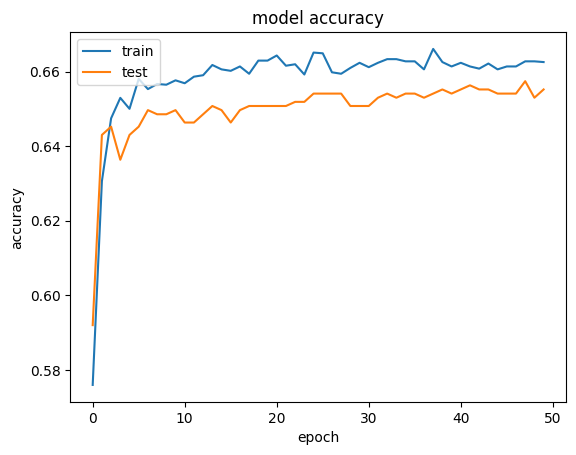

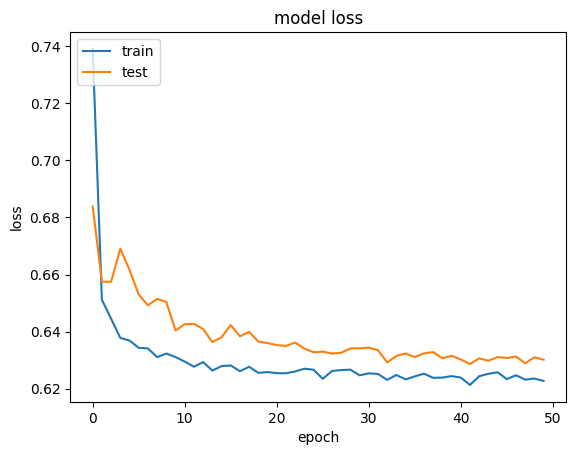

In [ ]:
%matplotlib inline

print(history.history.keys())
# Precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Matriz de confusión

Confusion matrix
[[269 200]
 [111 322]]
Normalized confusion matrix
[[0.57356077 0.42643923]
 [0.25635104 0.74364896]]


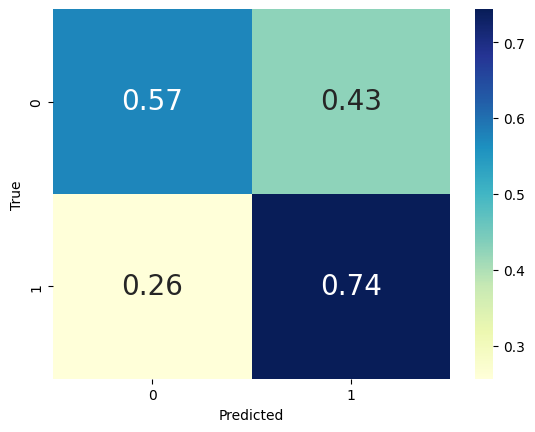

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

## LSTM  
https://github.com/LeadingIndiaAI/-Fake-News-Detection-/blob/master/LSTM-Conv.ipynb

### Arquitectura y entrenamiento

In [ ]:
# Modelo LSTM
embedding_dim = 100
dropout_rate = 0.5

modell = Sequential()
modell.add(tf.keras.layers.Embedding(max_features_textos, embedding_dim))
modell.add(Dropout(dropout_rate))
modell.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=3))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=dropout_rate, recurrent_dropout=dropout_rate))
modell.add(BatchNormalization())
modell.add(Dense(64, activation='relu'))
modell.add(Dropout(dropout_rate))
modell.add(Dense(32, activation='relu'))
modell.add(Dropout(dropout_rate))
modell.add(Dense(1, activation='sigmoid'))

modell.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy','AUC'])


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='models/checkpoint_rnn_model.keras',
    monitor='val_loss', save_best_only=True, verbose=1) # Guarda el epoch con mejores valores durante el entrenamiento
]

history = modell.fit(
    X_train_texto,
    y_train,
    epochs=8,
    batch_size=32,
    callbacks=callbacks,
    validation_data=(X_test_texto,y_test)
)

modell.summary()

# modell.save('data/lstm.keras')

Epoch 1/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - AUC: 0.5101 - accuracy: 0.5070 - loss: 0.7424
Epoch 1: val_loss improved from inf to 0.69255, saving model to models/checkpoint_rnn_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 418ms/step - AUC: 0.5103 - accuracy: 0.5071 - loss: 0.7422 - val_AUC: 0.6044 - val_accuracy: 0.4800 - val_loss: 0.6925
Epoch 2/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - AUC: 0.5747 - accuracy: 0.5668 - loss: 0.6910
Epoch 2: val_loss improved from 0.69255 to 0.69172, saving model to models/checkpoint_rnn_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 72s 355ms/step - AUC: 0.5748 - accuracy: 0.5668 - loss: 0.6910 - val_AUC: 0.6615 - val_accuracy: 0.6397 - val_loss: 0.6917
Epoch 3/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - AUC: 0.6103 - accuracy: 0.5914 - loss: 0.6776
Epoch 3: val_loss improved from 0.69172 to 0.68670, saving model to models/checkpoint_rnn_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 76s 320ms/step - AUC: 0.6103 - accuracy: 0.5914 - loss: 0.6776

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 759, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 759, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 759, 128)            │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 253, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 253, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 126, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,414,037 (13.02 MB)

 Trainable params: 1,137,945 (4.34 MB)

 Non-trainable params: 200 (800.00 B)

 Optimizer params: 2,275,892 (8.68 MB)

### Guardado y carga del modelo

In [ ]:
# --------------- Guardar modelo ----------------
modell.save('models/LSTM_model.keras')

In [ ]:
# --------------- Cargar modelo ----------------
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
modell = tf.keras.models.load_model('models/LSTM_model.keras')

### Prediccion y evaluación

In [ ]:
accuracy_train = modell.evaluate(X_train_texto, y_train, return_dict=True)
accuracy = modell.evaluate(X_test_texto, y_test, return_dict=True)

modelo = "LSTM"


# Se muestra
print(accuracy_train['accuracy'])
print(accuracy['accuracy'])

160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - AUC: 0.7019 - accuracy: 0.6536 - loss: 0.6385
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - AUC: 0.6533 - accuracy: 0.5715 - loss: 0.6746
0.641010582447052
0.5787139534950256


In [ ]:
# Recall y TNR
y_est = np.round(modell.predict(X_test_texto))
y_est_train = np.round(modell.predict(X_train_texto))


tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR

recall = recall_score(y_test, y_est)
recall_train = recall_score(y_train, y_est_train)

# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy['accuracy'], 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

print("TNR TRAIN",tnr_train)
print("TNR TEST",tnr)
print("recall TRAIN",recall_train)
print("recall TEST", recall)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step
TNR TRAIN 0.9596711041503524
TNR TEST 0.8805970149253731
recall TRAIN 0.3221003134796238
recall TEST 0.2517321016166282


dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])


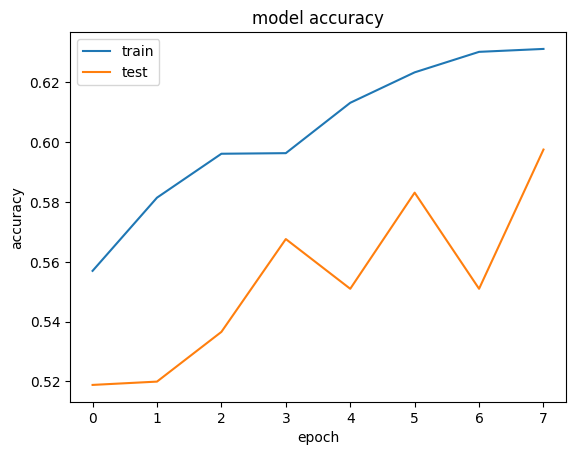

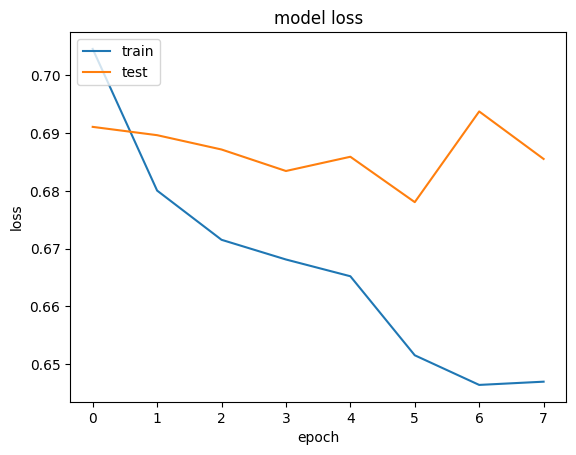

In [ ]:
print(history.history.keys())
# Precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Matriz de confusión

Confusion matrix
[[394  75]
 [288 145]]
Normalized confusion matrix
[[0.84008529 0.15991471]
 [0.66512702 0.33487298]]


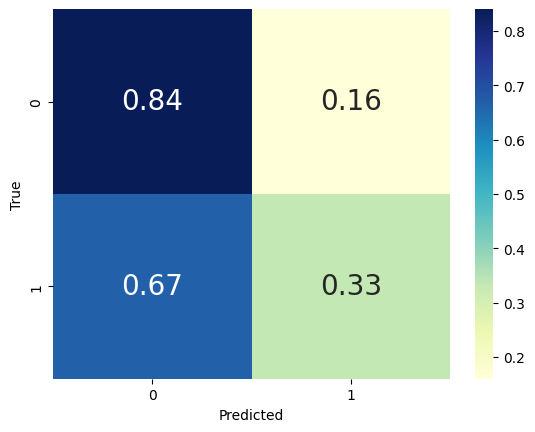

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

## GRU  
https://github.com/LeadingIndiaAI/-Fake-News-Detection-/blob/master/LSTM-Conv.ipynb

### Arquitectura y entrenamiento

In [ ]:
X_train_texto.shape

(5106, 759)

In [ ]:
# Modelo GRU
embedding_dim = 100

modelg = Sequential()
modelg.add(tf.keras.layers.Embedding(max_features_textos, embedding_dim))
# modelg.add(GRU(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
# modelg.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))
modelg.add(GRU(100, return_sequences=True))
modelg.add(GRU(100))

###
modelg.add(BatchNormalization())
modelg.add(Dense(64, activation='relu'))
###
modelg.add(Dense(1, activation='sigmoid'))


modelg.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(0.01),
              metrics=['accuracy','AUC'])


history = modelg.fit(
    X_train_texto,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test_texto,y_test)
)

modelg.summary()

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - AUC: 0.5796 - accuracy: 0.5759 - loss: 0.6814 - val_AUC: 0.6401 - val_accuracy: 0.6009 - val_loss: 0.6896
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - AUC: 0.6249 - accuracy: 0.6237 - loss: 0.6628 - val_AUC: 0.6409 - val_accuracy: 0.6242 - val_loss: 0.6893
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - AUC: 0.6240 - accuracy: 0.6246 - loss: 0.6623 - val_AUC: 0.6390 - val_accuracy: 0.6364 - val_loss: 0.6887
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - AUC: 0.6264 - accuracy: 0.6253 - loss: 0.6616 - val_AUC: 0.6376 - val_accuracy: 0.6364 - val_loss: 0.6880
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - AUC: 0.6270 - accuracy: 0.6244 - loss: 0.6610 - val_AUC: 0.6389 - val_accuracy: 0.6386 - val_loss: 0.6872
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - AUC: 0.6280 - accuracy: 0.6264 - loss: 0.6603 - val_AUC: 0.6389 - val_accuracy: 0.6386 - val_loss: 0.6862
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 759, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 759, 100)            │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 100)                 │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,128,131 (4.30 MB)

 Trainable params: 1,127,929 (4.30 MB)

 Non-trainable params: 200 (800.00 B)

 Optimizer params: 2 (12.00 B)

### Guardado y carga del modelo

In [ ]:
# --------------- Guardar modelo ----------------
modelg.save('models/GRU_model.keras')

In [ ]:
# --------------- Cargar modelo ----------------
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
modelg = tf.keras.models.load_model('models/GRU_model.keras')

### Predicción y evaluación

In [ ]:
accuracy_train = modelg.evaluate(X_train_texto, y_train, return_dict=True)
accuracy = modelg.evaluate(X_test_texto, y_test, return_dict=True)

modelo = "GRU"


# Se muestra
print(accuracy_train['accuracy'])
print(accuracy['accuracy'])

160/160 ━━━━━━━━━━━━━━━━━━━━ 43s 269ms/step - AUC: 0.6480 - accuracy: 0.6366 - loss: 0.6764
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - AUC: 0.6440 - accuracy: 0.6325 - loss: 0.6781
0.6284763216972351
0.6374722719192505


In [ ]:
# Recall y TNR
y_est = np.round(modelg.predict(X_test_texto))
y_est_train = np.round(modelg.predict(X_train_texto))


tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR

recall = recall_score(y_test, y_est)
recall_train = recall_score(y_train, y_est_train)

# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy['accuracy'], 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

print("TNR TRAIN",tnr_train)
print("TNR TEST",tnr)
print("recall TRAIN",recall_train)
print("recall TEST", recall)

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 50s 310ms/step
TNR TRAIN 0.7239624119028975
TNR TEST 0.7270788912579957
recall TRAIN 0.5329153605015674
recall TEST 0.5404157043879908


dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])


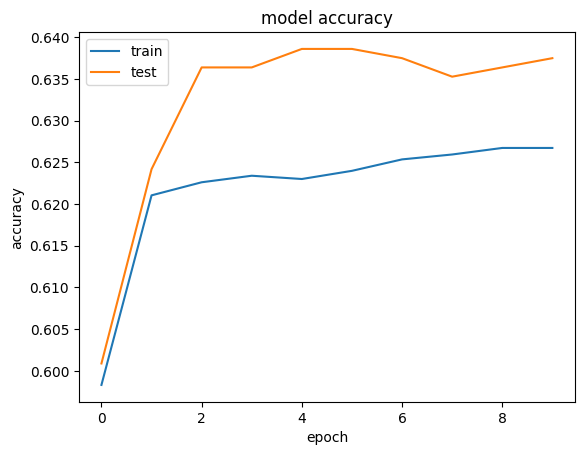

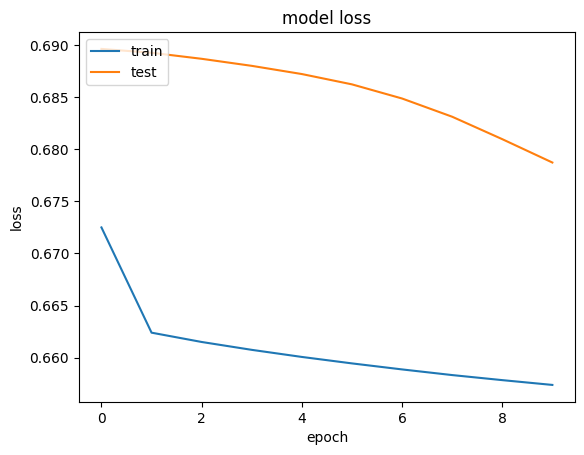

In [ ]:
print(history.history.keys())
# Precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Matriz de confusión

Confusion matrix
[[341 128]
 [199 234]]
Normalized confusion matrix
[[0.72707889 0.27292111]
 [0.4595843  0.5404157 ]]


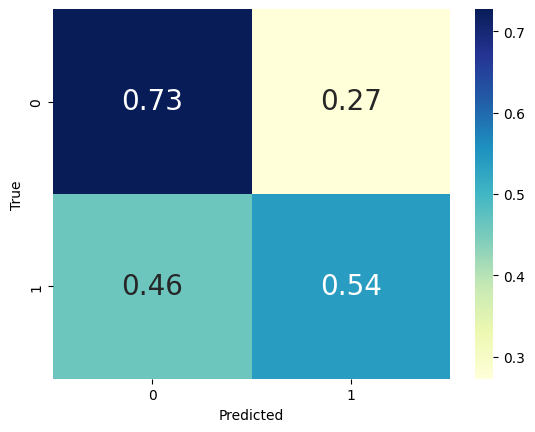

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

## CONV
https://github.com/LeadingIndiaAI/-Fake-News-Detection-/blob/master/CNN.ipynb

### Arquitectua y entrenamiento

In [ ]:
# Red Convolucional

RandomState(42)
tf.random.set_seed(42)
np.random.seed(42)

embedding_dim = 100 # 150

sequence_input = Input(shape=(sequence_length_textos,), dtype='int32')
embedded_sequences = Embedding(max_features_textos, embedding_dim)(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D()(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(5)(l_cov3)
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(1, activation='sigmoid')(l_dense)

modelc = Model(sequence_input, preds)
modelc.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adadelta(0.1), # Se beneficia de altos learning rate
              metrics=['accuracy'])


history = modelc.fit(X_train_texto, y_train, validation_data=(X_test_texto, y_test),
          epochs=40, batch_size=128)

modelc.summary()

Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5692 - loss: 0.6903 - val_accuracy: 0.6275 - val_loss: 0.6823
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6511 - loss: 0.6774 - val_accuracy: 0.6541 - val_loss: 0.6617
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6616 - loss: 0.6524 - val_accuracy: 0.6630 - val_loss: 0.6314
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6588 - loss: 0.6275 - val_accuracy: 0.6619 - val_loss: 0.6268
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6589 - loss: 0.6237 - val_accuracy: 0.6619 - val_loss: 0.6248
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6607 - loss: 0.6213 - val_accuracy: 0.6619 - val_loss: 0.6228
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6629 - loss: 0.6188 - val_accuracy: 0.6641 - val_loss: 0.6205
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6676 - loss: 0.6163 - val_accuracy: 0.6608 - val_loss:

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 759)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 759, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 755, 128)            │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 377, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 373, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 74, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 70, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         229,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,373,573 (16.68 MB)

 Trainable params: 1,457,857 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,915,716 (11.12 MB)

### Guardado y carga del modelo

In [ ]:
# --------------- Guardar modelo ----------------
modelc.save('models/CONV_model.keras')

In [ ]:
# --------------- Cargar modelo ----------------
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
modelc = tf.keras.models.load_model('models/CONV_model.keras')

### Predicción y evaluación

In [ ]:
accuracy_train = modelc.evaluate(X_train_texto, y_train, return_dict=True)
accuracy = modelc.evaluate(X_test_texto, y_test, return_dict=True)

modelo = "Red neuronal convolucional"

print(accuracy_train['accuracy'], accuracy['accuracy'])

160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.7195 - loss: 0.5642
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6952 - loss: 0.6026
0.7201331853866577 0.6884700655937195


In [ ]:
# Recall y TNR
y_est = np.round(modelc.predict(X_test_texto))
y_est_train = np.round(modelc.predict(X_train_texto))


tnr = recall_score(y_test, y_est, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR
tnr_train = recall_score(y_train, y_est_train, pos_label=0) # Indicando pos_label=0 se indica se que calcula el TNR no el TPR

recall = recall_score(y_test, y_est)
recall_train = recall_score(y_train, y_est_train)

# Se añade al dataframe de precisiones
añadir_modelo = pd.Series({'Modelo':modelo,'Precision':accuracy['accuracy'], 'TNR':tnr, 'Recall':recall})
tabla_comparativa = pd.concat([tabla_comparativa, añadir_modelo], axis=1)

print("TNR TRAIN",tnr_train)
print("TNR TEST",tnr)
print("recall TRAIN",recall_train)
print("recall TEST", recall)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step
TNR TRAIN 0.6726703210649961
TNR TEST 0.6311300639658849
recall TRAIN 0.7676332288401254
recall TEST 0.7505773672055427


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


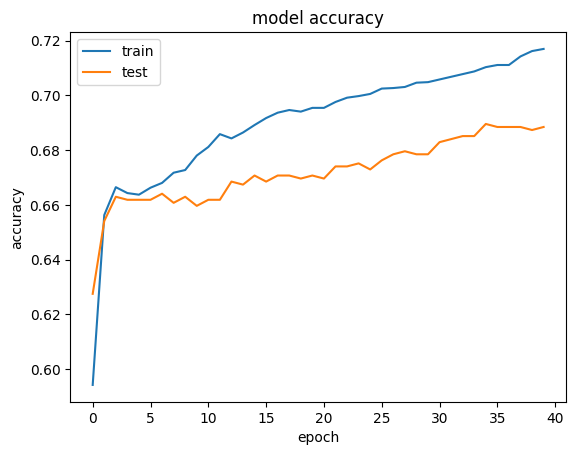

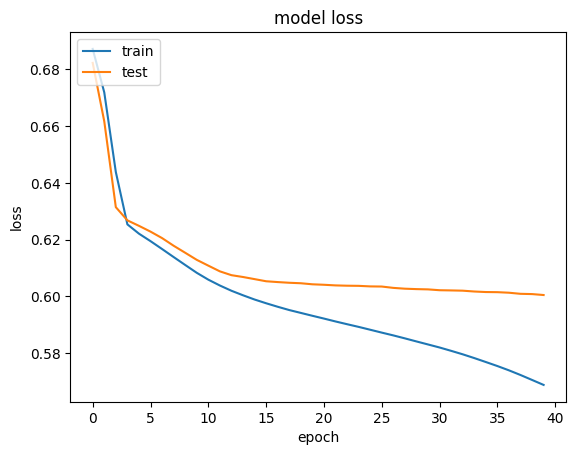

In [ ]:
print(history.history.keys())
# Precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Matriz de confusión

Confusion matrix
[[296 173]
 [112 321]]
Normalized confusion matrix
[[0.63113006 0.36886994]
 [0.25866051 0.74133949]]


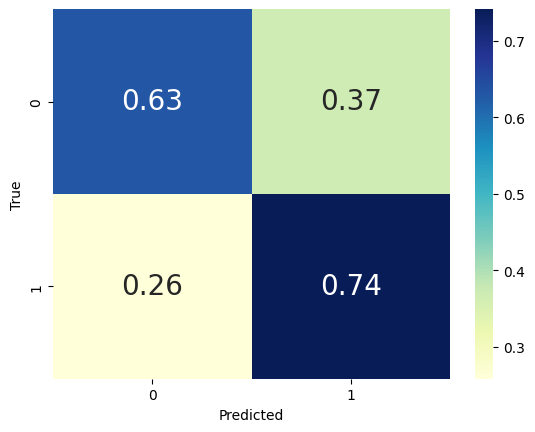

In [ ]:
CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

# Tabla comparación de modelos y conclusiones

In [ ]:
# Guardar el dataframe
with open('data/tabla_comparativa.pkl', 'wb') as f:
    joblib.dump(tabla_comparativa, f, compress=9) # Se usa compress para que comprima los datos lo que se traduce en un mayor tiempo de carga pero libera mucho espacio, 9 es el mayor nivel de compresion.

In [ ]:
# Descargar desde Colab a local
from google.colab import files

# Especifica el archivo que deseas descargar
files.download('data/tabla_comparativa.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Cargar el dataframe de comparativa
with open('data/tabla_comparativa.pkl', 'rb') as f:
    tabla_comparativa = joblib.load(f)

# Esructura de los datos
print(f"Claves del dataframe datos_preprocesados: {tabla_comparativa.keys()}\n")

Claves del dataframe datos_preprocesados: Index(['Modelo', 'Precision', 'TNR', 'Recall'], dtype='object')



In [ ]:
tabla_comparativa = tabla_comparativa.T

In [4]:
tabla_comparativa


,Modelo,Precision,TNR,Recall
0,Regresión logística,0.682927,0.554371,0.822171
1,KNNeighbors,0.596452,0.533049,0.665127
2,Suppor Vector Machine,0.730599,0.733475,0.727483
3,Árbol de decisión,0.721729,0.673774,0.773672
4,Bagging de tocones,0.706208,0.533049,0.893764
5,RandomForest,0.779379,0.759062,0.801386
6,Bagging de árboles,0.784922,0.778252,0.792148
7,LSTM,0.578714,0.880597,0.251732
8,GRU,0.637472,0.727079,0.540416
9,Red neuronal convolucional,0.68847,0.63113,0.750577


In [ ]:
# Guardar en formato excel
writer = pd.ExcelWriter('data/tabla_comparativa.xlsx')
tabla_comparativa.to_excel(writer)
writer.close()

### Visualizaciones

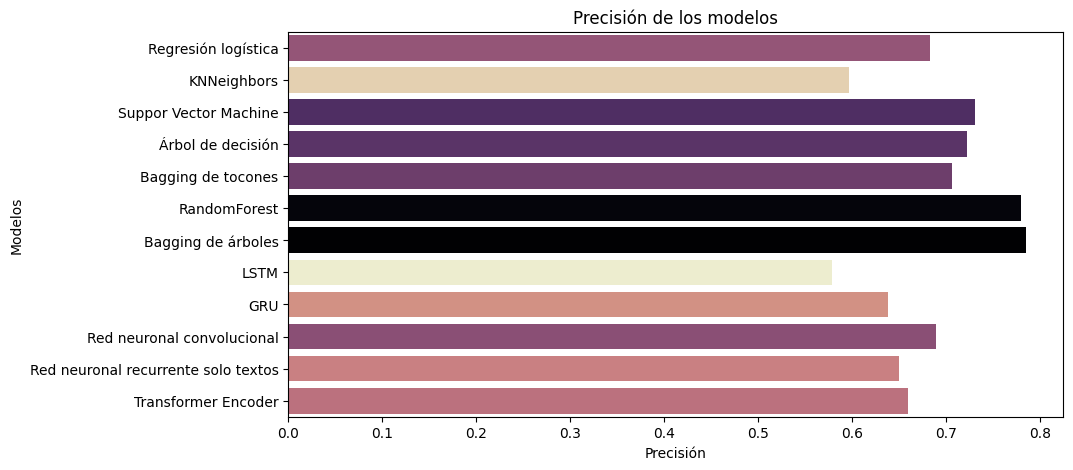

In [26]:
plt.figure(figsize=(10,5))

figura = sns.barplot(x='Precision', y= 'Modelo', data=tabla_comparativa, palette='magma_r', hue='Precision', legend=False, saturation=0.5)


plt.ylabel('Modelos')
plt.xlabel('Precisión')
plt.title('Precisión de los modelos')

plt.show;

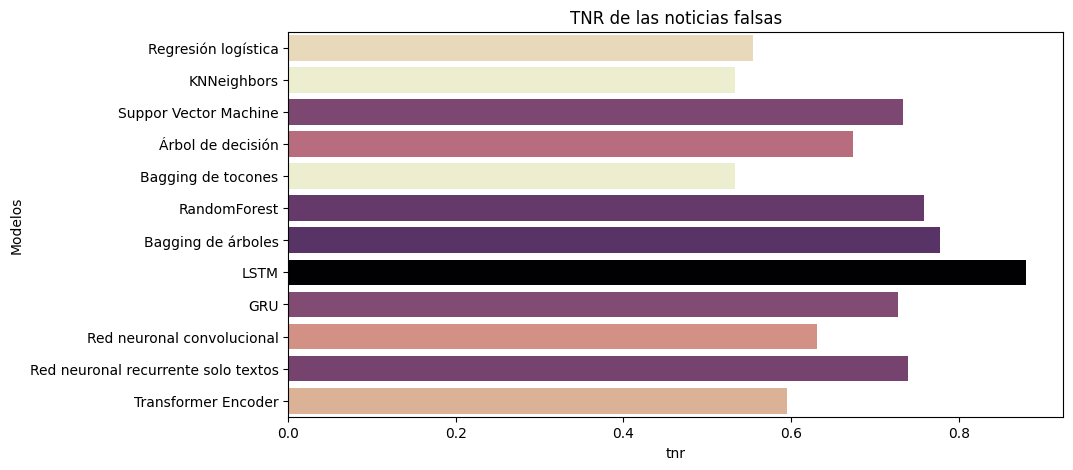

In [27]:
plt.figure(figsize=(10,5))

figura = sns.barplot(x='TNR', y= 'Modelo', data=tabla_comparativa, palette='magma_r', hue='TNR', legend=False, saturation=0.5)


plt.ylabel('Modelos')
plt.xlabel('tnr')
plt.title('TNR de las noticias falsas')

plt.show;